# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [5]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [6]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

## 1 Load dataset

In [7]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
# train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None, load=False)


Better to keep validation and testing set in RAM, but not always possible

In [ ]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=1, nfile=None)

In [ ]:
val_nonrot_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, experiment='deepsphere_norot', augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [8]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere')

In [9]:
dataset = train_TFDataset.get_tf_dataset(32)

In [10]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
#     try:
    for i in tqdm(range(steps)):
        print(i)
        out = sess.run(data_next)
        print(out)
#     except tf.errors.OutOfRangeError:
#         print("Done") 

  0%|          | 0/2941 [00:00<?, ?it/s]

0


  0%|          | 3/2941 [00:01<22:05,  2.22it/s]  

(array([[[ 6.57924831e-01,  4.26984936e-01,  1.36249304e+00,
          1.48620307e+00, -2.56532025e+00,  1.62585127e+00],
        [ 6.23443007e-01,  3.82890135e-01,  1.38574529e+00,
          1.42286670e+00, -2.71711326e+00,  1.65232885e+00],
        [ 6.64920032e-01,  4.37765628e-01,  1.35624230e+00,
          1.49898028e+00, -2.52823305e+00,  1.61872280e+00],
        ...,
        [ 8.10806632e-01,  1.27389944e+00, -7.71590471e-02,
          1.76234484e+00,  4.94579732e-01, -2.20277026e-01],
        [ 8.10015202e-01,  1.25782120e+00, -1.97592061e-02,
          1.76106775e+00,  4.41291869e-01, -1.48866832e-01],
        [ 8.09651375e-01,  1.25058270e+00,  5.30909002e-03,
          1.76052999e+00,  4.19275463e-01, -1.20284028e-01]],

       [[ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          4.92733687e-01, -1.02455139e+00,  1.08457410e+00],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          4.30090845e-01, -1.13793397e+00,  1.14387035e+00],
        [ 8.6703

  0%|          | 11/2941 [00:01<07:11,  6.79it/s]

(array([[[-0.8415183 ,  1.0946299 ,  0.45497942, -0.2218927 ,
         -0.25583497,  0.5703878 ],
        [-0.7947813 ,  1.1221675 ,  0.38610077, -0.16448605,
         -0.16065156,  0.49003786],
        [-0.8223764 ,  1.1057241 ,  0.4276877 , -0.19863574,
         -0.21791363,  0.53890896],
        ...,
        [-1.752061  ,  0.91152394,  0.83084476, -1.2917873 ,
         -0.874455  ,  1.0002621 ],
        [-1.6217848 ,  0.9426478 ,  0.77568555, -1.1729784 ,
         -0.7820783 ,  0.94488186],
        [-1.6085255 ,  0.9470782 ,  0.7675724 , -1.1569134 ,
         -0.76700795,  0.9355833 ]],

       [[ 0.59181404, -0.9352397 ,  0.2675321 , -0.84333897,
          1.2023785 , -2.02805   ],
        [ 0.58358777, -0.904745  ,  0.35079896, -0.83716214,
          1.2134053 , -2.1584575 ],
        [ 0.59352535, -0.9418132 ,  0.24886185, -0.84502435,
          1.1993781 , -2.000115  ],
        ...,
        [ 0.83840215, -0.9425123 ,  0.24686027, -0.60114336,
          0.97794014, -1.1008077 ],
 

  1%|          | 19/2941 [00:01<04:48, 10.11it/s]

(array([[[ 1.2997409 , -0.7532809 ,  0.69682944, -0.66355574,
         -0.41571668,  0.6958708 ],
        [ 1.2850373 , -0.78384125,  0.6348724 , -0.68832535,
         -0.44678473,  0.7189757 ],
        [ 1.3113011 , -0.73067516,  0.74043995, -0.5762868 ,
         -0.3012107 ,  0.60716313],
        ...,
        [ 0.00324439, -0.9558027 ,  0.20822324, -0.8712193 ,
         -0.6587641 ,  0.8665312 ],
        [ 0.03611413, -0.9981805 ,  0.07695087, -1.0220524 ,
         -0.81333506,  0.9639291 ],
        [ 0.01706647, -0.9732237 ,  0.15580848, -0.89900064,
         -0.6885037 ,  0.8859064 ]],

       [[-0.9864844 ,  0.6867624 ,  1.1460718 , -1.4150282 ,
         -1.7981615 ,  1.4228972 ],
        [-1.0132595 ,  0.6786239 ,  1.1550653 , -1.4336418 ,
         -1.8084123 ,  1.4264164 ],
        [-0.86232656,  0.7277768 ,  1.0983653 , -1.1763864 ,
         -1.6556039 ,  1.3715167 ],
        ...,
        [ 0.05374832,  1.1193173 ,  0.39340892,  0.50615036,
         -0.15991963,  0.48940262],
 

  1%|          | 25/2941 [00:02<04:06, 11.83it/s]

(array([[[ 0.6081119 , -1.1613505 , -0.5994667 ,  0.28487042,
          0.29320487,  0.03412119],
        [ 0.6114101 , -1.1778231 , -0.69271785,  0.26193807,
          0.23714975,  0.09821377],
        [ 0.6058014 , -1.150056  , -0.5394483 ,  0.3163714 ,
          0.3729189 , -0.06174185],
        ...,
        [ 0.21189871,  1.3517392 , -0.39606318,  0.6949979 ,
          0.7330901 , -0.5879629 ],
        [ 0.19888341,  1.3276575 , -0.28900394,  0.6662487 ,
          0.6284089 , -0.41554722],
        [ 0.2109214 ,  1.3498981 , -0.38756135,  0.6843304 ,
          0.6936508 , -0.52063495]],

       [[-0.34628272,  1.4110087 , -0.7058954 ,  0.39960933,
          0.83859545, -0.7853344 ],
        [-0.35613224,  1.4005765 , -0.6453423 ,  0.3875199 ,
          0.8020441 , -0.7137751 ],
        [-0.35865998,  1.3654478 , -0.4611917 ,  0.38473356,
          0.68642277, -0.5086227 ],
        ...,
        [-1.0733739 , -1.1620082 , -0.6030538 , -0.57932216,
         -0.4417606 ,  0.7152661 ],
 

  1%|          | 32/2941 [00:02<03:34, 13.59it/s]

(array([[[ 2.46893346e-01, -3.41912925e-01,  1.25839090e+00,
          8.74615669e-01, -2.12250376e+00,  1.52330458e+00],
        [ 1.82961643e-01,  5.30245602e-01,  1.29325116e+00,
          7.65345752e-01, -2.27122903e+00,  1.56205273e+00],
        [ 2.61788726e-01, -3.53163213e-01,  1.24855673e+00,
          8.91052842e-01, -2.09722805e+00,  1.51627350e+00],
        ...,
        [ 6.18661702e-01, -1.02544355e+00, -1.48169389e-02,
          1.46335196e+00,  9.08060223e-02,  2.54180849e-01],
        [ 6.13514602e-01, -1.00366426e+00,  5.89863360e-02,
          1.45505035e+00,  1.48055246e-02,  3.29403639e-01],
        [ 6.12914085e-01,  1.23177302e+00,  6.83596656e-02,
          1.45293498e+00, -4.06425819e-03,  3.47522825e-01]],

       [[-4.32432443e-01,  1.51975644e+00, -1.92871213e+00,
          2.02303886e-01,  1.21157670e+00, -2.13217521e+00],
        [-4.34355289e-01,  1.51768172e+00, -1.83257270e+00,
          2.02238217e-01,  1.21138525e+00, -2.12957358e+00],
        [-4.3403

  1%|▏         | 39/2941 [00:02<03:13, 14.99it/s]

(array([[[ 2.2666245 , -1.0596956 , -0.13969003, -0.11286596,
          0.4292313 , -0.13314518],
        [ 2.2975116 , -1.0343196 , -0.04608788, -0.15639284,
          0.34197873, -0.0238409 ],
        [ 2.2643392 , -1.0616175 , -0.14705086, -0.10964502,
          0.43584085, -0.14174184],
        ...,
        [ 3.4812043 , -1.2580278 , -1.3246968 , -1.9637712 ,
         -1.5270582 ,  1.3211781 ],
        [-2.6439388 , -0.41758806,  1.1869774 , -2.369491  ,
         -1.7270551 ,  1.3978419 ],
        [ 3.4645936 , -1.2668105 , -1.4345984 , -2.2276962 ,
         -1.6616716 ,  1.3737977 ]],

       [[-1.877648  ,  0.764366  ,  1.0523403 , -2.035437  ,
          0.24016878,  0.09482736],
        [-0.25462246, -0.241259  ,  1.3347533 , -1.934158  ,
         -1.2312385 ,  1.1899798 ],
        [-1.8037447 ,  0.82863826,  0.9631089 , -2.1235738 ,
          0.23015851,  0.10602815],
        ...,
        [-0.38954377, -0.35821173,  1.2440561 ,  0.15610695,
          0.9466952 , -1.0228157 ],
 

  2%|▏         | 46/2941 [00:02<02:57, 16.27it/s]

(array([[[ 0.64276266, -1.0639536 , -0.1560517 ,  1.545135  ,
          0.44402546, -0.15245225],
        [ 0.63786435, -1.0387441 , -0.06194926,  1.5382707 ,
          0.35734698, -0.04255317],
        [ 0.6434244 , -1.0674428 , -0.16960825,  1.5460612 ,
          0.4560083 , -0.16826603],
        ...,
        [ 0.44925404, -0.5176651 ,  1.0725496 ,  1.2737842 ,
         -1.4349989 ,  1.2827017 ],
        [ 0.40685982, -0.45933613,  1.1421177 ,  1.2143368 ,
         -1.635575  ,  1.3639276 ],
        [ 0.42232835, -0.47933045,  1.1191957 ,  1.2360268 ,
         -1.5668238 ,  1.337166  ]],

       [[ 0.79559237, -1.2501225 , -1.2385889 , -0.77219415,
          1.0840423 , -1.4164715 ],
        [ 0.7953443 , -1.2453935 , -1.1913095 , -0.78133947,
          1.0677805 , -1.3612574 ],
        [ 0.79507405, -1.2402852 , -1.1431134 , -0.79128957,
          1.0502154 , -1.3049729 ],
        ...,
        [-1.4746689 , -1.2074934 , -0.8825592 , -0.95803744,
          0.9374581 , -1.0006952 ],
 

  2%|▏         | 50/2941 [00:02<02:51, 16.83it/s]

(array([[[-0.4380017 ,  1.4436369 , -0.9194163 ,  0.06915892,
          0.9385604 , -1.0033145 ],
        [-0.38226297, -1.1985413 , -0.82176954,  0.0513921 ,
          0.89384776, -0.90125734],
        [-0.36293852, -1.2191862 , -0.96767694,  0.08278129,
          0.97344804, -1.0892729 ],
        ...,
        [-2.6575596 , -0.4509365 ,  1.1514664 , -2.381267  ,
         -1.6638553 ,  1.3746164 ],
        [-2.6172755 , -1.1908873 , -0.772357  , -2.333925  ,
          0.8895991 , -0.8919724 ],
        [-2.631526  , -1.185554  , -0.7391726 , -2.3506923 ,
          0.8716729 , -0.8535078 ]],

       [[ 0.00969495,  0.79355526,  1.0131781 ,  0.46263507,
         -1.2800847 ,  1.2131857 ],
        [-0.01416317,  0.77519655,  1.0380675 ,  0.4237637 ,
         -1.3432131 ,  1.2422523 ],
        [-0.0331716 ,  0.76126623,  1.0563698 ,  0.3927938 ,
         -1.3911132 ,  1.2636259 ],
        ...,
        [ 2.4863367 ,  1.4177084 , -0.7465135 , -0.81505704,
          0.8988385 , -0.9122506 ],
 

  2%|▏         | 57/2941 [00:03<02:41, 17.89it/s]


53
(array([[[ 1.4417793 , -0.4696416 ,  1.1304218 , -0.07197852,
          0.8264654 , -0.7611716 ],
        [ 1.4833244 , -0.4301976 ,  1.1738487 , -0.04805017,
          0.882138  , -0.8758257 ],
        [ 1.424208  , -0.4880945 ,  1.1088476 , -0.08602072,
          0.794431  , -0.69932413],
        ...,
        [ 1.1441246 , -1.0981987 , -0.29543364, -1.8678002 ,
         -2.0766335 ,  1.5104474 ],
        [ 1.1509525 , -1.0690111 , -0.17574647, -1.5269154 ,
         -1.4995813 ,  1.3099097 ],
        [-2.1102552 ,  0.6681699 ,  1.1663924 , -1.7342857 ,
         -1.6214565 ,  1.3585218 ]],

       [[ 0.08385096, -0.15847203,  1.3825282 ,  0.85890234,
         -2.6698327 ,  1.6445436 ],
        [ 0.07094548, -0.1539974 ,  1.3847371 ,  0.8424137 ,
         -2.685094  ,  1.647102  ],
        [-0.06212467, -0.11537998,  1.4022387 ,  0.6724034 ,
         -2.8178082 ,  1.6675297 ],
        ...,
        [ 0.76182795, -0.6163798 ,  0.93502647,  1.6243999 ,
         -0.7336836 ,  0.9147521 

  2%|▏         | 65/2941 [00:03<02:32, 18.83it/s]

(array([[[ 0.12036822,  0.80966604,  0.9906004 ,  0.8411044 ,
         -0.8254962 ,  0.9712539 ],
        [ 0.1545839 ,  0.84302497,  0.9415947 ,  0.87307715,
         -0.73518574,  0.9156991 ],
        [ 0.09155279,  0.78387135,  1.0264168 ,  0.8020178 ,
         -0.9284831 ,  1.0313997 ],
        ...,
        [ 0.20496269, -1.0808927 , -0.2231831 ,  0.855775  ,
          0.51579684, -0.24964064],
        [ 0.2231709 , -1.1147255 , -0.36831987,  0.8829414 ,
          0.63062054, -0.41899234],
        [ 0.21242386, -1.0945292 , -0.27978256,  0.86670756,
          0.56124973, -0.3144731 ]],

       [[-0.2625724 ,  0.78595567,  1.0235882 ,  0.2787959 ,
         -0.5479849 ,  0.7915505 ],
        [-0.20716684,  0.8205374 ,  0.9749684 ,  0.33421233,
         -0.43667337,  0.7114996 ],
        [-0.3057791 ,  0.7612552 ,  1.0563841 ,  0.28967622,
         -0.5267508 ,  0.7766548 ],
        ...,
        [ 0.38490766, -1.0862956 , -0.24532203,  1.199558  ,
          0.6277268 , -0.4144862 ],
 

  2%|▏         | 73/2941 [00:03<02:26, 19.62it/s]

(array([[[-0.83380574,  0.83426136,  0.9547693 , -0.18695559,
         -1.140105  ,  1.1449705 ],
        [-0.8209842 ,  0.83972085,  0.9465873 , -0.1715289 ,
         -1.121332  ,  1.1354154 ],
        [-0.75135195,  0.87088174,  0.89825106, -0.0877488 ,
         -1.0141828 ,  1.0789671 ],
        ...,
        [-0.83784467,  1.3462188 , -0.37073675, -0.19181466,
          0.6203141 , -0.40300468],
        [-0.8000494 ,  1.3741215 , -0.5041866 , -0.14634055,
          0.7162588 , -0.55885154],
        [-0.8276311 ,  1.3536366 , -0.40488365, -0.1795256 ,
          0.64582086, -0.44288298]],

       [[ 0.692702  , -0.9155062 ,  0.32202443,  0.7126384 ,
         -0.50821835,  0.76351225],
        [ 0.6888349 , -0.893132  ,  0.38113964,  0.7228779 ,
         -0.48026034,  0.74343055],
        [ 0.68953866, -0.89713115,  0.37077284,  0.75108176,
         -0.40058088,  0.68446904],
        ...,
        [-0.87293816, -1.2082272 , -0.8876987 , -0.4279716 ,
         -2.0556583 ,  1.5044237 ],
 

  3%|▎         | 77/2941 [00:03<02:23, 19.97it/s]

73
(array([[[ 0.14765577,  1.31646   , -0.24203447, -0.06203514,
         -0.9492471 ,  1.0431274 ],
        [ 0.14731978, -1.0859175 , -0.24376051, -0.12224817,
         -1.0301439 ,  1.0875853 ],
        [ 0.1331788 ,  1.2939534 , -0.15234128,  0.01597925,
         -0.836576  ,  0.9778857 ],
        ...,
        [ 0.1112937 ,  0.86608744,  0.90587234,  0.9046586 ,
          0.8792169 , -0.869558  ],
        [ 0.11244875,  0.7953828 ,  1.0106517 ,  0.88918686,
          0.8076072 , -0.72443044],
        [ 0.13282527,  0.6257587 ,  1.2098011 ,  0.9022942 ,
          0.8681245 , -0.8460252 ]],

       [[ 1.4790076 , -0.5897149 ,  0.97476715,  1.105536  ,
          0.7839411 , -0.67965275],
        [ 1.5011241 , -0.6866988 ,  0.8202201 ,  1.1105171 ,
          0.8131737 , -0.73517454],
        [ 1.4523015 , -0.62259406,  0.9254752 ,  1.0945657 ,
          0.7208976 , -0.566817  ],
        ...,
        [-1.0056847 ,  1.0737076 ,  0.50484633, -0.39395535,
         -0.31246072,  0.6161345 ]

  3%|▎         | 84/2941 [00:04<02:19, 20.51it/s]

(array([[[ 9.09616724e-02,  1.14904475e+00,  3.15035462e-01,
          9.25706744e-01, -5.76963350e-02,  3.97873461e-01],
        [ 7.09818676e-02,  1.12310362e+00,  3.83691251e-01,
          9.01667118e-01, -1.46896958e-01,  4.78051364e-01],
        [ 1.06036998e-01,  1.16951859e+00,  2.58141786e-01,
          9.43845153e-01,  1.27068013e-02,  3.31429392e-01],
        ...,
        [ 4.37267460e-02,  1.08985710e+00,  4.66536909e-01,
          8.68872106e-01, -2.61604577e-01,  5.75116992e-01],
        [-1.54897175e-03,  1.03875732e+00,  5.83753467e-01,
          8.14398408e-01, -4.36222583e-01,  7.11165309e-01],
        [ 2.09399574e-02,  1.06344163e+00,  5.28578103e-01,
          8.41456473e-01, -3.51821154e-01,  6.47076130e-01]],

       [[ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          4.88341361e-01,  1.01317191e+00, -1.19556057e+00],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          5.00890434e-01,  1.05589104e+00, -1.32281172e+00],
        [-2.7318

  3%|▎         | 91/2941 [00:04<02:15, 21.04it/s]

(array([[[ 0.20673494,  0.91358584,  0.827288  ,  1.0650074 ,
         -0.86734337,  0.99609584],
        [ 0.22456135,  0.93573004,  0.7882212 ,  1.086456  ,
         -0.79119855,  0.95047265],
        [ 0.22694226,  0.9387811 ,  0.7827121 ,  1.0893205 ,
         -0.78070724,  0.94403905],
        ...,
        [-1.4394355 ,  1.1757848 ,  0.24022111, -0.9156388 ,
          0.0342514 ,  0.31050363],
        [-1.3614026 ,  1.2129133 ,  0.12875223, -0.82175195,
          0.16191949,  0.18032849],
        [-1.3784151 ,  1.2045987 ,  0.15453781, -0.8422202 ,
          0.13333066,  0.21044031]],

       [[-0.56333673,  1.0895275 ,  0.467331  ,  0.09958769,
         -0.20101267,  0.52465457],
        [-0.6130799 ,  1.056792  ,  0.54370016,  0.04041076,
         -0.31196815,  0.61574286],
        [-0.563635  ,  1.0893244 ,  0.46782017,  0.1001747 ,
         -0.19987516,  0.5236902 ],
        ...,
        [-1.0736102 ,  0.83341175,  0.95603496, -0.56945056,
         -1.140474  ,  1.1451572 ],
 

  3%|▎         | 99/2941 [00:04<02:11, 21.55it/s]

(array([[[-0.45501694,  0.84450555,  0.9393474 , -1.9251065 ,
          0.87727433, -0.865406  ],
        [-0.5133229 ,  0.81371176,  0.98482084, -1.8790658 ,
          0.93255633, -0.98911744],
        [-0.40598148,  0.8726362 ,  0.8954451 , -1.9350262 ,
          0.86553866, -0.8405997 ],
        ...,
        [ 0.3099876 , -1.0103914 ,  0.03661697,  1.1892318 ,
          0.2597123 ,  0.07272819],
        [ 0.31409538, -1.0187557 ,  0.00827726,  1.1941744 ,
          0.28847396,  0.03963213],
        [ 0.30359513, -0.9976185 ,  0.07877849,  1.1815404 ,
          0.21579179,  0.12196546]],

       [[ 0.76164955, -1.2635916 , -1.392166  ,  1.7326688 ,
          1.1303502 , -1.5957909 ],
        [ 0.76136464, -1.2598699 , -1.3463097 ,  1.7323253 ,
          1.1175401 , -1.5421896 ],
        [ 0.76224595, -1.2714367 , -1.5012889 ,  1.7333863 ,
          1.1573256 , -1.7232141 ],
        ...,
        [ 0.6056471 , -1.1860077 , -0.7419585 ,  1.2943178 ,
         -2.1359172 ,  1.5269827 ],
 

  4%|▎         | 107/2941 [00:04<02:08, 22.06it/s]

(array([[[ 0.02440117, -0.4748652 ,  1.124397  ,  0.1516065 ,
         -1.2645272 ,  1.205863  ],
        [-0.01793014, -0.44660968,  1.156218  ,  0.09029355,
         -1.3458713 ,  1.2434536 ],
        [-0.01363847, -0.4482304 ,  1.1544434 ,  0.07818565,
         -1.3612727 ,  1.2503792 ],
        ...,
        [-0.1868655 ,  0.74003875,  1.083313  , -0.5421795 ,
          0.42929953, -0.13323367],
        [-0.2903165 ,  0.68435335,  1.1487502 , -0.58052576,
          0.01139474,  0.3326947 ],
        [-0.21354878,  0.72367716,  1.1033158 , -0.52294785,
          0.09895723,  0.24589151]],

       [[-0.40432364,  0.81020284,  0.9898359 , -1.2755052 ,
         -0.20178348,  0.52530795],
        [-0.41273713,  0.80563545,  0.9963141 , -1.1807063 ,
         -0.09545577,  0.4323412 ],
        [-0.47786072,  0.79976964,  1.0045515 , -1.2735724 ,
         -0.19968015,  0.5235248 ],
        ...,
        [ 1.4149251 ,  0.67864895,  1.1550379 ,  0.24961843,
         -0.20406453,  0.5272389 ],
 

  4%|▍         | 111/2941 [00:04<02:07, 22.24it/s]

107
(array([[[-0.54032856,  1.3105189 , -0.21776907, -0.06208762,
          0.9342843 , -0.9931865 ],
        [-0.5130603 ,  1.0347902 ,  0.59238034, -0.0526524 ,
          0.9567156 , -1.0472764 ],
        [-0.55722654,  1.2963403 , -0.16157484, -0.08446273,
          0.8819586 , -0.8754397 ],
        ...,
        [-0.16690804,  0.9326146 ,  0.7938146 ,  0.22527076,
         -0.80079174,  0.95632404],
        [-0.14048776,  0.9540422 ,  0.75468445,  0.2669973 ,
         -0.7271391 ,  0.91061705],
        [-0.18111521,  0.921539  ,  0.81344074,  0.20282444,
         -0.83887696,  0.9792582 ]],

       [[-0.4333144 , -1.2239486 , -1.0045209 , -0.08242375,
          0.25839335,  0.07422926],
        [-0.42183423, -1.235879  , -1.1036035 , -0.0873071 ,
          0.24868494,  0.08523547],
        [-0.43086907, -1.2264719 , -1.0246236 , -0.03787815,
          0.34925398, -0.0326716 ],
        ...,
        [-0.98349714, -1.1784825 , -0.6966084 , -1.7998378 ,
         -1.557943  ,  1.333628  

  4%|▍         | 119/2941 [00:05<02:04, 22.69it/s]

(array([[[ 0.78800607, -0.93294847,  0.27397737,  0.39172447,
         -0.9117386 ,  1.0218462 ],
        [ 0.78994316, -0.95928764,  0.197902  ,  0.45543426,
         -0.7892257 ,  0.9492657 ],
        [ 0.78660357, -0.9146663 ,  0.32429358,  0.36022055,
         -0.9684735 ,  1.0538702 ],
        ...,
        [ 0.6307876 , -0.77781045,  0.6473818 ,  0.8839683 ,
         -0.8707942 ,  0.9981194 ],
        [ 0.6435896 , -0.8289901 ,  0.5365403 ,  0.9475908 ,
         -0.67956007,  0.88011235],
        [ 0.63632333, -0.7992444 ,  0.6022697 ,  0.91476417,
         -0.7814455 ,  0.94449294]],

       [[ 0.89419764,  0.5062732 ,  1.3112164 ,  1.1061347 ,
         -2.1541848 ,  1.5319328 ],
        [ 0.89179546,  0.5441973 ,  1.2822562 ,  1.1661072 ,
         -2.028118  ,  1.496376  ],
        [ 0.8962057 ,  0.4793725 ,  1.3300008 ,  1.0524164 ,
         -2.2511978 ,  1.5570925 ],
        ...,
        [ 0.7156861 ,  1.4381177 , -0.8802091 ,  1.459717  ,
          0.53319526, -0.2741388 ],
 

  4%|▍         | 127/2941 [00:05<02:02, 23.06it/s]

(array([[[ 1.84035683e+00, -9.45438921e-01,  2.38448694e-01,
          1.46920681e-01,  1.17514186e-01,  2.26853043e-01],
        [ 1.86355960e+00, -9.20736909e-01,  3.07801813e-01,
          1.09238088e-01,  3.72240655e-02,  3.07593882e-01],
        [ 1.85315704e+00,  1.16145086e+00,  2.80858666e-01,
          1.24149732e-01,  6.85793236e-02,  2.76562095e-01],
        ...,
        [-4.11912173e-01, -9.71109450e-01,  1.62280992e-01,
         -5.94677171e-03, -3.09377164e-01,  6.13681078e-01],
        [-4.28288728e-01, -9.57371891e-01,  2.03585476e-01,
         -3.80677939e-03, -3.05584431e-01,  6.10657632e-01],
        [-3.99045914e-01, -9.82151747e-01,  1.28127083e-01,
          3.58457081e-02, -2.33696684e-01,  5.52094400e-01]],

       [[-1.35035431e+00,  4.42939550e-01,  1.35316288e+00,
         -8.46671045e-01, -2.44458055e+00,  1.60168123e+00],
        [-1.17524803e+00,  4.71015990e-01,  1.33554339e+00,
         -6.48262262e-01, -2.35776758e+00,  1.58256996e+00],
        [-1.6414

  4%|▍         | 131/2941 [00:05<02:00, 23.26it/s]

127
(array([[[ 0.7771821 ,  1.2273123 ,  0.08289036,  1.3481866 ,
          0.01280935,  0.33133063],
        [ 0.77863324,  1.2455598 ,  0.02243568,  1.3601637 ,
          0.09975051,  0.24508253],
        [ 0.7784895 ,  1.2437247 ,  0.02863938,  1.3530881 ,
          0.04789253,  0.29710576],
        ...,
        [-0.10584293,  1.5065007 , -1.5680068 ,  0.24973604,
          1.174818  , -1.8214357 ],
        [-0.11249972,  1.4970478 , -1.4248043 ,  0.23898333,
          1.1430566 , -1.6529661 ],
        [-0.11088549,  1.4993285 , -1.4562094 ,  0.24166155,
          1.1509286 , -1.6908199 ]],

       [[ 0.5752227 , -1.1811937 , -0.7127422 ,  1.5083624 ,
          0.84703237, -0.8023971 ],
        [ 0.5755219 , -1.1825235 , -0.7207385 ,  1.5087222 ,
          0.8516049 , -0.8117356 ],
        [ 0.5710921 , -1.1630942 , -0.60900044,  1.5033923 ,
          0.7847957 , -0.6812448 ],
        ...,
        [-0.34638157, -0.2339881 ,  1.3394814 ,  0.39949805,
         -2.4100153 ,  1.594247  

  5%|▍         | 139/2941 [00:05<01:58, 23.56it/s]

(array([[[-0.6958092 , -0.8177897 ,  0.56173015, -0.5951881 ,
          0.05618459,  0.28890368],
        [-0.72261125, -0.8257718 ,  0.54383403, -0.6384921 ,
         -0.00613158,  0.3494949 ],
        [-0.64889556, -0.89955974,  0.36443588, -0.53814703,
          0.14344577,  0.19985268],
        ...,
        [-0.42806494, -0.73723376,  0.7279753 ,  0.08038419,
          0.35566825, -0.04049823],
        [ 3.1151655 , -0.84186774,  0.5068966 ,  0.12600544,
          0.460081  , -0.17367724],
        [-0.39543608, -0.37314174,  1.2304276 ,  0.08866885,
          0.37423012, -0.06336815]],

       [[ 1.2291344 ,  0.9286893 ,  0.80081636,  2.1931353 ,
         -1.0347728 ,  1.0900708 ],
        [ 1.2214681 ,  0.94628   ,  0.76903903,  2.184698  ,
         -0.96792245,  1.0535642 ],
        [ 1.2454666 ,  0.89359415,  0.86120874,  2.2099128 ,
         -1.1581446 ,  1.1540602 ],
        ...,
        [ 0.44950435,  1.0639256 ,  0.5274698 ,  1.1078295 ,
         -0.04717161,  0.388124  ],
 

  5%|▍         | 147/2941 [00:06<01:56, 23.88it/s]

(array([[[-0.6062642 , -1.2336091 , -1.0839155 ,  0.08681761,
          1.0272659 , -1.2358618 ],
        [-0.61943203, -1.221658  , -0.9866272 ,  0.07097455,
          0.9861714 , -1.1222463 ],
        [-0.6113651 , -1.2289541 , -1.0448197 ,  0.08068033,
          1.0112591 , -1.1902043 ],
        ...,
        [-0.9226246 , -0.929724  ,  0.28299478, -0.2938207 ,
         -0.01767053,  0.36045578],
        [-0.8947472 , -0.94626254,  0.23607188, -0.26027912,
          0.03919893,  0.30565783],
        [-0.9394171 , -0.920008  ,  0.3097931 , -0.31402498,
         -0.05107957,  0.39175153]],

       [[-2.4123404 , -1.2026285 , -0.84909797, -2.0862238 ,
          0.92073655, -0.96163416],
        [-2.419033  , -1.199944  , -0.8310708 , -2.094276  ,
          0.91150546, -0.94058204],
        [-2.4519358 , -1.1869034 , -0.7474774 , -2.1338642 ,
          0.86666435, -0.84295905],
        ...,
        [-0.5714258 , -1.2385144 , -1.127021  ,  0.05648984,
          0.9986615 , -1.1555654 ],
 

  5%|▌         | 155/2941 [00:06<01:55, 24.18it/s]

(array([[[-2.1527598 , -0.50427586,  1.0892516 , -1.9995346 ,
         -0.44844103,  0.7201962 ],
        [ 1.4794695 , -0.54310656,  1.0395694 , -1.8658819 ,
         -0.33495474,  0.63390154],
        [-2.238453  , -0.4870992 ,  1.1100322 , -1.9742942 ,
          0.45308775, -0.16439684],
        ...,
        [ 0.04125774, -1.0324064 , -0.03928631,  0.8659064 ,
          0.33540863, -0.01590815],
        [ 0.06217781, -1.0622426 , -0.14945348,  0.8910774 ,
          0.43800294, -0.14456409],
        [ 0.04451315, -1.0369498 , -0.05549416,  0.8698233 ,
          0.35103124, -0.03483632]],

       [[ 1.5022862 , -0.35913002,  1.2432317 ,  2.0868187 ,
         -1.979715  ,  1.4818474 ],
        [ 1.3835795 , -0.3697165 ,  1.2335967 ,  2.0818207 ,
         -1.9430319 ,  1.4705076 ],
        [ 1.5649647 , -0.31649897,  1.2796272 ,  2.109248  ,
         -2.1262648 ,  1.5243396 ],
        ...,
        [ 0.37455338,  1.1577744 ,  0.29108086,  1.2669204 ,
         -0.02764969,  0.36987147],
 

  5%|▌         | 159/2941 [00:06<01:54, 24.28it/s]

(array([[[ 0.19544785, -1.0942048 , -0.27840802,  1.0514209 ,
          0.5479134 , -0.29516873],
        [ 0.20742446, -1.116169  , -0.37488264,  1.0658313 ,
          0.6234389 , -0.40783405],
        [ 0.1955274 , -1.0943477 , -0.27901343,  1.0515167 ,
          0.5484051 , -0.295876  ],
        ...,
        [-1.6226215 ,  1.2973565 , -0.1655247 , -1.1360441 ,
          0.45228496, -0.16333543],
        [-1.6334178 , -1.0612924 , -0.14580265, -1.1490341 ,
          0.43473762, -0.1403035 ],
        [-1.594856  ,  1.3106859 , -0.21844523, -1.1026372 ,
          0.49811926, -0.22513731]],

       [[-1.5547893 , -1.2462474 , -1.1996453 , -1.1186858 ,
          1.0528331 , -1.3131617 ],
        [-1.5473586 , -1.2504382 , -1.2418466 , -1.1073885 ,
          1.0705944 , -1.3705841 ],
        [-1.5752803 , -1.2348225 , -1.0943868 , -1.1447784 ,
          1.0123205 , -1.193173  ],
        ...,
        [-0.9182218 , -1.1716491 , -0.65690506, -0.35823908,
          0.85163164, -0.8117901 ],
 

  6%|▌         | 167/2941 [00:06<01:53, 24.54it/s]

(array([[[ 0.31642783,  1.3707114 , -0.48710868, -0.6344236 ,
         -0.5927243 ,  0.82237625],
        [ 0.31326973,  1.3635526 , -0.45198795, -0.7378334 ,
         -0.71292275,  0.90158415],
        [ 0.30813336,  1.3520931 , -0.3977037 , -0.5992405 ,
         -0.54952455,  0.7926237 ],
        ...,
        [ 1.1447077 ,  1.431175  , -0.8328702 ,  0.65736014,
          0.546544  , -0.2931998 ],
        [ 1.1402044 ,  1.4528657 , -0.9885389 ,  0.68806607,
          0.6555431 , -0.4583641 ],
        [ 1.1418225 ,  1.4449902 , -0.9292608 ,  0.6777495 ,
          0.6182915 , -0.3998866 ]],

       [[ 0.3275008 ,  0.967644  ,  0.7290279 ,  1.2102698 ,
         -0.6814598 ,  0.88134533],
        [ 0.30577394,  0.93465567,  0.7901537 ,  1.1841266 ,
         -0.7948925 ,  0.9527295 ],
        [ 0.3208841 ,  0.95731944,  0.74856174,  1.2023079 ,
         -0.71696174,  0.90415764],
        ...,
        [-0.00927578,  0.64014846,  1.1955249 ,  0.80503726,
         -1.8075858 ,  1.4261336 ],
 

  6%|▌         | 175/2941 [00:07<01:51, 24.74it/s]

(array([[[-0.0574582 , -1.2788358 , -1.6290162 ,  0.3650493 ,
          1.1827803 , -1.8724436 ],
        [-0.06103931, -1.2734554 , -1.5330551 ,  0.35926092,
          1.16428   , -1.760379  ],
        [-0.05956623, -1.2756634 , -1.5701604 ,  0.36164168,
          1.1718715 , -1.8037082 ],
        ...,
        [-0.1432748 , -1.1989886 , -0.82472724,  0.61485356,
          0.9114591 , -0.9404772 ],
        [-0.13967396, -1.2036903 , -0.8563115 ,  0.6184985 ,
          0.9247439 , -0.970884  ],
        [-0.14912087, -1.1914266 , -0.7757675 ,  0.6072224 ,
          0.883896  , -0.87961185]],

       [[ 0.7050808 ,  0.4932248 ,  1.3205082 ,  0.8508389 ,
         -2.1400564 ,  1.5281103 ],
        [ 0.6956153 ,  0.47236657,  1.334657  ,  0.81410754,
         -2.1917663 ,  1.5419043 ],
        [ 0.6886802 ,  0.45847136,  1.3436062 ,  0.75320673,
         -2.2699347 ,  1.5617347 ],
        ...,
        [ 0.33657467, -1.052014  , -0.11066662,  1.1452254 ,
          0.72625786, -0.57607573],
 

  6%|▌         | 183/2941 [00:07<01:50, 24.91it/s]

(array([[[-4.78059739e-01, -4.38404977e-01,  1.16510916e+00,
          2.41048172e-01, -1.70750749e+00,  1.39075541e+00],
        [-4.17941242e-01, -4.64177191e-01,  1.13665462e+00,
          3.13390464e-01, -1.61840963e+00,  1.35734940e+00],
        [-4.14734930e-01, -4.65627164e-01,  1.13500750e+00,
          3.17250341e-01, -1.61342072e+00,  1.35542452e+00],
        ...,
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.55624592e+00,  7.87069023e-01, -6.85489893e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.51370108e+00,  8.42549503e-01, -7.93304265e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.55986881e+00,  7.82408655e-01, -6.76801860e-01]],

       [[-8.49288702e-03, -1.10982144e+00, -3.46266955e-01,
          7.47269869e-01,  5.62658012e-01, -3.16526055e-01],
        [-5.83942514e-04, -1.12099040e+00, -3.97046655e-01,
          7.57115185e-01,  5.99938452e-01, -3.71883035e-01],
        [ 2.7753

  6%|▋         | 187/2941 [00:07<01:49, 25.05it/s]

183
(array([[[ 1.23800069e-01,  1.10112369e+00,  4.39078152e-01,
          7.10735202e-01, -1.86560974e-01,  5.12353897e-01],
        [ 1.37395948e-01,  1.51844144e+00, -1.86254585e+00,
          7.44556069e-01, -8.26603621e-02,  4.20749754e-01],
        [ 1.13763809e-01,  1.08799124e+00,  4.71025467e-01,
          6.94433033e-01, -2.34488815e-01,  5.52753150e-01],
        ...,
        [-6.22544289e-01,  1.43773067e+00, -8.77513647e-01,
         -7.91113004e-02,  1.14019656e+00, -1.63970184e+00],
        [-6.44593596e-01,  1.41844392e+00, -7.51061916e-01,
         -8.48060846e-02,  1.12627780e+00, -1.57835007e+00],
        [-6.40806913e-01,  1.42171609e+00, -7.71522462e-01,
         -8.91904980e-02,  1.11561847e+00, -1.53445220e+00]],

       [[ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          1.35699046e+00,  8.88634086e-01, -8.89872909e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          1.36176813e+00,  9.31830466e-01, -9.87411618e-01],
        [ 8.

  7%|▋         | 195/2941 [00:07<01:49, 25.19it/s]

(array([[[ 6.11707747e-01, -8.17119479e-01,  5.63220561e-01,
         -2.39112854e-01, -8.55689764e-01,  9.89233851e-01],
        [ 6.10815704e-01, -8.13860476e-01,  5.70439517e-01,
         -1.55575886e-01, -7.41435528e-01,  9.19631302e-01],
        [ 6.02245510e-01, -7.83781767e-01,  6.34996653e-01,
         -2.13903919e-01, -8.22181344e-01,  9.69262123e-01],
        ...,
        [-1.46115756e+00, -6.01646841e-01,  9.57230687e-01,
         -1.67225957e+00, -1.60042727e+00,  1.35038435e+00],
        [-1.35596788e+00,  6.01958334e-02,  1.44733858e+00,
         -1.41910076e+00, -1.44512498e+00,  1.28703535e+00],
        [-1.74282694e+00, -4.65677500e-01,  1.13495028e+00,
         -1.58666956e+00, -1.02886701e+00,  1.08689868e+00]],

       [[-4.20023829e-01, -5.23905754e-01,  1.06461167e+00,
         -5.92983842e-01,  4.95670289e-01, -2.21772954e-01],
        [-3.80486131e-01, -5.44169724e-01,  1.03815520e+00,
         -6.39564991e-01,  4.19110119e-01, -1.20071307e-01],
        [-5.0091

  7%|▋         | 202/2941 [00:07<01:48, 25.30it/s]

(array([[[-1.18022725e-01,  9.76530075e-01,  7.11913288e-01,
          6.74254596e-01, -6.50901794e-01,  8.61356974e-01],
        [-1.41956240e-01,  9.56105709e-01,  7.50833631e-01,
          6.45457923e-01, -7.21132696e-01,  9.06809092e-01],
        [-1.49295986e-01,  9.50034916e-01,  7.62120783e-01,
          6.36626899e-01, -7.42007613e-01,  9.19990540e-01],
        ...,
        [-3.62359017e-01,  1.33418381e+00, -3.17166835e-01,
          2.02904090e-01,  3.17367554e-01,  5.67219639e-03],
        [-3.50931436e-01,  1.34561837e+00, -3.68010849e-01,
          2.07046688e-01,  3.27217102e-01, -6.07314706e-03],
        [-3.70184451e-01,  1.32647562e+00, -2.83967674e-01,
          1.80209622e-01,  2.64268368e-01,  6.75316751e-02]],

       [[ 6.05107248e-01,  1.50961077e+00, -1.62534750e+00,
         -4.15355572e-03,  1.19790447e+00, -1.98711336e+00],
        [ 6.05958104e-01,  1.51415241e+00, -1.72611332e+00,
         -1.15361088e-03,  1.20565879e+00, -2.06133413e+00],
        [ 6.0439

  7%|▋         | 210/2941 [00:08<01:46, 25.55it/s]


203
(array([[[ 0.58669215, -1.1983399 , -0.8204405 ,  0.3737224 ,
          1.0304598 , -1.2452103 ],
        [ 0.58971083, -1.21264   , -0.91915745,  0.38556027,
          1.0677428 , -1.3611327 ],
        [ 0.58725256, -1.2009709 , -0.8379309 ,  0.36544278,
          1.004733  , -1.1721246 ],
        ...,
        [ 0.41419387, -0.29431388,  1.2970722 ,  0.07534367,
          1.20518   , -2.0562677 ],
        [ 0.47377563, -0.35642508,  1.2456551 ,  0.07413008,
          1.2019061 , -2.0235076 ],
        [ 0.43755314, -0.31662512,  1.279525  ,  0.07189094,
          1.195877  , -1.969889  ]],

       [[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.47183955,
          1.1149373 , -1.5317259 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.48057726,
          1.1448877 , -1.6615888 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.5068526 ,
         -0.688366  ,  0.8858174 ],
        ...,
        [-0.37912002,  0.53866714,  1.2866621 , -0.13394654,
         -1.4589828 ,  1.2929252

  7%|▋         | 214/2941 [00:08<01:46, 25.62it/s]

210
(array([[[ 0.22580013,  1.0047754 ,  0.65559274, -0.9213743 ,
         -0.44202733,  0.71546334],
        [ 0.20812714,  0.9809229 ,  0.7033477 , -0.961555  ,
         -0.48717406,  0.74842536],
        [ 0.24607255,  1.0338075 ,  0.5945072 , -1.0141015 ,
         -0.5443094 ,  0.7889846 ],
        ...,
        [ 0.344831  ,  1.2074791 ,  0.145661  , -1.2578408 ,
          0.14322859,  0.2000806 ],
        [ 0.32319072,  1.1640271 ,  0.27364704, -1.3870233 ,
         -0.00618516,  0.34954613],
        [ 0.33644164,  1.1902138 ,  0.19800566, -1.3079202 ,
          0.08385973,  0.26121026]],

       [[ 0.77667576, -0.84765947,  0.49332014,  1.7507485 ,
         -0.29983556,  0.60606253],
        [ 0.7794933 , -0.8786547 ,  0.4179698 ,  1.7541385 ,
         -0.19325696,  0.5180663 ],
        [ 0.77704686, -0.85162896,  0.48392603,  1.7511951 ,
         -0.28618464,  0.5950906 ],
        ...,
        [ 0.56805193, -0.03875817,  1.4287971 ,  1.3195621 ,
         -1.563609  ,  1.3358877 

  8%|▊         | 222/2941 [00:08<01:45, 25.82it/s]

(array([[[-0.15594073, -0.4750972 ,  1.1241281 ,  0.6286397 ,
         -1.5809515 ,  1.3427558 ],
        [-0.10049745, -0.5089393 ,  1.0834849 ,  0.6953484 ,
         -1.4645823 ,  1.2952917 ],
        [-0.12783806, -0.49177942,  1.1044413 ,  0.66245264,
         -1.5235881 ,  1.3197651 ],
        ...,
        [ 0.6501726 , -0.27177662,  1.3137679 ,  1.052745  ,
         -2.2800858 ,  1.5642204 ],
        [ 0.66465044, -0.2994791 ,  1.2931007 ,  1.1066022 ,
         -2.1848283 ,  1.540085  ],
        [ 0.6434665 , -0.26016092,  1.3219736 ,  1.0277988 ,
         -2.3200274 ,  1.5738035 ]],

       [[-1.494847  , -0.06589349,  1.4206216 , -0.98230845,
         -2.9879992 ,  1.6890028 ],
        [-0.45743665, -0.05492526,  1.4240879 , -1.0214309 ,
         -2.898922  ,  1.678421  ],
        [-0.13167953, -0.11050256,  1.4042515 , -0.42139813,
         -2.8346312 ,  1.6698873 ],
        ...,
        [ 0.56833357, -1.2024584 , -0.847946  ,  1.5000701 ,
          0.92015123, -0.96028894],
 

  8%|▊         | 230/2941 [00:08<01:44, 25.95it/s]

(array([[[-0.84910876, -1.0708226 , -0.18287143, -0.46025437,
          0.34470713, -0.02714668],
        [-0.82092065, -1.0906333 , -0.26336548, -0.41407207,
          0.425073  , -0.12776046],
        [-0.8361715 , -1.0798334 , -0.21888508, -0.44935188,
          0.3633894 , -0.04997126],
        ...,
        [-0.9557604 , -1.2695607 , -1.4733181 , -0.42694208,
          1.1398726 , -1.6382147 ],
        [-0.9663058 , -1.2616117 , -1.3673835 , -0.44669607,
          1.0991718 , -1.4710065 ],
        [-0.9664246 , -1.2615048 , -1.3660707 , -0.44183514,
          1.109123  , -1.5088203 ]],

       [[-0.22049643, -0.99924463,  0.07348345,  0.3830015 ,
          0.43979922, -0.14691287],
        [-0.19482704, -1.0261915 , -0.01742416,  0.4125197 ,
          0.52245015, -0.25896344],
        [-0.22650556, -0.9931189 ,  0.09332261,  0.37817302,
          0.42659217, -0.12972544],
        ...,
        [-1.926164  ,  1.4842036 , -1.2714047 , -2.1226022 ,
          0.6514142 , -0.4517703 ],
 

  8%|▊         | 238/2941 [00:09<01:43, 26.10it/s]

(array([[[-0.5877167 ,  1.0930376 ,  0.45884764, -0.29086164,
         -0.15517518,  0.48527732],
        [-0.5715814 ,  1.1040015 ,  0.43196496, -0.2683072 ,
         -0.11853683,  0.45302504],
        [-0.63752604,  1.0606749 ,  0.5348934 , -0.36043552,
         -0.263506  ,  0.5766722 ],
        ...,
        [-1.2456924 ,  0.95420045,  0.7543898 , -0.78611416,
         -0.6479842 ,  0.8594312 ],
        [-1.1303593 ,  1.0026127 ,  0.660011  , -0.6491723 ,
         -0.48620826,  0.74772865],
        [-1.1614875 ,  0.9889995 ,  0.6874152 , -0.6844607 ,
         -0.5295633 ,  0.77863765]],

       [[-1.9222894 , -1.2817843 , -1.69198   , -1.4974353 ,
          1.200982  , -2.0147855 ],
        [-1.9166555 , -1.284612  , -1.7644558 , -1.4921119 ,
          1.2086257 , -2.0946922 ],
        [-1.9183273 , -1.2837718 , -1.7412325 , -1.493541  ,
          1.206571  , -2.071216  ],
        ...,
        [-2.1166742 , -1.2711262 , -1.4965616 , -1.7338458 ,
          1.145088  , -1.6625382 ],
 

  8%|▊         | 242/2941 [00:09<01:43, 26.15it/s]

(array([[[-4.92148995e-01, -1.03002644e+00, -3.08724344e-02,
         -5.87609470e-01,  1.32425889e-01,  2.11383581e-01],
        [-5.23057759e-01, -1.00455594e+00,  5.60422949e-02,
         -6.53106034e-01,  3.48260626e-02,  3.09941947e-01],
        [-4.78590131e-01, -1.04156864e+00, -7.21731335e-02,
         -5.93552947e-01,  1.23354085e-01,  2.20812991e-01],
        ...,
        [-2.15569162e+00,  6.20931029e-01,  1.21448791e+00,
         -1.77742529e+00, -1.87366199e+00,  1.44827759e+00],
        [-2.12031341e+00,  1.19872332e+00,  1.72463313e-01,
         -1.73485899e+00,  1.13153994e-01,  2.31347188e-01],
        [-1.99353385e+00,  6.49583638e-01,  1.18591368e+00,
         -1.58231986e+00, -1.77513754e+00,  1.41490781e+00]],

       [[ 5.71099758e-01,  7.86402524e-01,  1.02298045e+00,
          1.18046284e+00,  6.26117766e-01, -4.11986828e-01],
        [ 7.18584418e-01,  1.30482292e+00, -1.94911167e-01,
          1.16812479e+00,  5.50486267e-01, -2.98873991e-01],
        [ 5.7372

  9%|▊         | 250/2941 [00:09<01:42, 26.24it/s]

(array([[[ 0.74915457, -1.162532  , -0.60591906,  1.6143119 ,
         -0.14584357,  0.4771294 ],
        [ 0.7475465 , -1.1453309 , -0.5151788 ,  1.6072198 ,
         -0.243289  ,  0.5600494 ],
        [ 0.7560214 , -0.04441413,  1.4272035 ,  1.6187515 ,
         -0.08192641,  0.42008215],
        ...,
        [ 0.76080596, -1.1401303 , -0.48899934,  1.6094769 ,
         -0.21287768,  0.5346763 ],
        [ 0.7581412 , -1.1094038 , -0.3444066 ,  1.5962607 ,
         -0.38353935,  0.67151624],
        [ 0.7591205 , -1.1205212 , -0.394873  ,  1.6022378 ,
         -0.30852512,  0.6130025 ]],

       [[-0.6105013 ,  1.2210337 ,  0.10308061, -0.13755274,
          0.21007864,  0.12825844],
        [-0.5991333 ,  1.2497858 ,  0.00804097, -0.16080363,
          0.16609447,  0.17588238],
        [-0.6487862 ,  1.193103  ,  0.18938865, -0.1800008 ,
          0.13053456,  0.21335445],
        ...,
        [-0.08609391,  1.292597  , -0.147122  ,  0.37222824,
          0.4795099 , -0.19975074],
 

  9%|▉         | 258/2941 [00:09<01:41, 26.36it/s]

(array([[[-0.04360522, -0.6807607 ,  0.8305042 , -1.5210679 ,
         -0.0288425 ,  0.37099317],
        [-1.6688036 , -0.6987897 ,  0.7989279 , -1.614761  ,
         -0.12546526,  0.45917833],
        [-0.07454687, -0.67933524,  0.83295614, -1.5494256 ,
         -0.05864776,  0.3987518 ],
        ...,
        [-1.7320236 , -0.7578787 ,  0.6877327 , -1.3512933 ,
          0.8619406 , -0.8330859 ],
        [-1.7279999 , -0.9505743 ,  0.2235581 , -1.4044294 ,
          0.7891101 , -0.6893117 ],
        [-1.7092524 , -0.76559824,  0.67228305, -1.3591713 ,
          0.8509913 , -0.81047857]],

       [[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.14546342,
          0.47445896, -0.19293062],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.13696437,
          0.45429698, -0.1659979 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.18027872,
          0.3995781 , -0.09514327],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.1151495 ,
          0.8853593 , -0.88277215],
 

  9%|▉         | 266/2941 [00:10<01:40, 26.50it/s]

(array([[[-0.14422098,  0.5539833 ,  1.2743047 , -1.6710285 ,
          0.97874695, -1.1028912 ],
        [-0.22089927,  0.71078855,  1.1186137 , -1.7063512 ,
          0.93327415, -0.9908062 ],
        [-0.13790566,  0.55673885,  1.2720299 , -1.6728498 ,
          1.0414428 , -1.2780064 ],
        ...,
        [-0.5068085 ,  0.98274827,  0.69976777,  0.20647602,
         -0.6295266 ,  0.84717757],
        [-0.44045976,  1.0267576 ,  0.60965025,  0.2863063 ,
         -0.47819674,  0.7419361 ],
        [-0.49231467,  0.99199545,  0.681444  ,  0.22391477,
         -0.59772944,  0.8257783 ]],

       [[ 0.18347824,  1.2831857 , -0.1114542 ,  0.6222289 ,
          0.3704708 , -0.05870957],
        [ 0.19752257,  1.3076801 , -0.20632868,  0.64830416,
          0.4562013 , -0.16852213],
        [ 0.1796374 ,  1.2766609 , -0.08726687,  0.6148177 ,
          0.34675804, -0.02963638],
        ...,
        [-1.0588353 ,  1.0910276 ,  0.4637127 , -0.5269586 ,
         -0.56080997,  0.80046403],
 

  9%|▉         | 274/2941 [00:10<01:40, 26.61it/s]

(array([[[-1.2401426 , -1.1662451 , -0.6264232 , -0.7593276 ,
         -1.5056705 ,  1.3124226 ],
        [-1.2179123 , -1.1737624 , -0.6690411 , -0.8638121 ,
         -1.589564  ,  1.3461403 ],
        [-1.1802884 , -0.48114964,  1.1170629 , -0.6038456 ,
         -1.5599445 ,  1.334427  ],
        ...,
        [ 0.01147399, -1.1292186 , -0.43577066,  0.67861557,
          0.6682786 , -0.4788878 ],
        [-0.00756731, -1.1021199 , -0.31236538,  0.65233415,
          0.57509595, -0.33477452],
        [ 0.00782626, -1.1239347 , -0.41077024,  0.67358136,
          0.6501102 , -0.44969368]],

       [[-0.38935748,  0.93597263,  0.7877843 ,  0.34779885,
         -0.7903643 ,  0.94996244],
        [-0.39875484,  0.92988116,  0.7986956 ,  0.3364921 ,
         -0.8113104 ,  0.96270496],
        [-0.44588652,  0.9006455 ,  0.84938747,  0.279784  ,
         -0.91183966,  1.0219042 ],
        ...,
        [-1.6519166 , -0.4195236 ,  1.1849855 , -1.1712979 ,
         -1.7719281 ,  1.4137849 ],
 

  9%|▉         | 278/2941 [00:10<01:39, 26.66it/s]

(array([[[-0.68005264,  1.0361587 ,  0.58941156, -0.7314274 ,
         -0.03485206,  0.37663105],
        [-0.9598767 ,  1.4098965 , -0.6992881 , -0.66367346,
          0.00701438,  0.33691093],
        [-0.68186504,  1.0350814 ,  0.59174913, -0.77313983,
         -0.09152564,  0.42879033],
        ...,
        [-1.361585  ,  1.0699441 ,  0.51360124, -0.9225362 ,
         -0.17626439,  0.50352615],
        [-1.0311608 ,  0.90152293,  0.8479057 , -0.8002038 ,
         -0.02902253,  0.37116227],
        [-1.3203887 ,  1.0879198 ,  0.4711967 , -0.87281036,
         -0.1137414 ,  0.44875148]],

       [[ 0.7368838 , -0.6720964 ,  0.8453083 ,  1.7028702 ,
         -0.9035447 ,  1.0171398 ],
        [ 0.7420439 , -0.70460796,  0.78851116,  1.7090787 ,
         -0.7917507 ,  0.9508104 ],
        [ 0.73882943, -0.6840471 ,  0.82482636,  1.7052112 ,
         -0.86245084,  0.9932202 ],
        ...,
        [ 0.3367248 ,  0.5614259 ,  1.2681241 ,  1.1942902 ,
         -2.0776012 ,  1.5107231 ],
 

 10%|▉         | 286/2941 [00:10<01:39, 26.76it/s]

(array([[[ 2.3303695 , -0.01954788,  1.4337761 , -1.2842273 ,
          0.9352361 , -0.99543333],
        [ 2.1741135 , -0.03569   ,  1.4296372 , -1.3225756 ,
          0.88043857, -0.8721751 ],
        [ 3.0409105 ,  0.02458683,  1.4426926 , -1.2835057 ,
          0.93627936, -0.9979017 ],
        ...,
        [ 0.5308576 , -1.0808604 , -0.22305152,  1.4549866 ,
          0.50202376, -0.23051666],
        [ 0.53289753, -1.0881631 , -0.2530604 ,  1.457441  ,
          0.527135  , -0.26556176],
        [ 0.53602517, -1.0995368 , -0.301187  ,  1.461204  ,
          0.56624424, -0.3217652 ]],

       [[-0.07761664, -0.9781126 ,  0.14072166,  0.43629405,
          0.18207829,  0.1587425 ],
        [-0.08776227, -0.9664918 ,  0.17630826,  0.42621592,
          0.15540123,  0.18724518],
        [-0.09937484, -0.9534908 ,  0.21502586,  0.40174773,
          0.09216964,  0.25279716],
        ...,
        [ 0.4196781 ,  1.3383119 , -0.33529675, -0.6344559 ,
          0.6014043 , -0.37410095],
 

 10%|▉         | 294/2941 [00:10<01:38, 26.88it/s]

(array([[[-0.6165663 , -0.16478157,  1.3793494 ,  0.07442491,
         -2.647992  ,  1.6408068 ],
        [-0.6636331 , -0.1561637 ,  1.3836725 ,  0.01779488,
         -2.6776252 ,  1.6458555 ],
        [-0.41461942, -0.20893322,  1.3549818 ,  0.3174012 ,
         -2.4961567 ,  1.6123465 ],
        ...,
        [ 0.46928734, -0.9298664 ,  0.28259796,  1.3809009 ,
         -0.01719928,  0.3600095 ],
        [ 0.46433222, -0.91700387,  0.31796795,  1.374939  ,
         -0.06141792,  0.40130618],
        [ 0.47402942, -0.9424802 ,  0.24695218,  1.3866068 ,
          0.0261846 ,  0.3183722 ]],

       [[ 0.57211787,  1.4734731 , -1.163786  ,  1.3839937 ,
          0.74186033, -0.60336566],
        [ 0.5712508 ,  1.4694914 , -1.1271645 ,  1.3799655 ,
          0.7052862 , -0.54017985],
        [ 0.56966263,  1.4622608 , -1.0643146 ,  1.3780075 ,
          0.6877308 , -0.51078916],
        ...,
        [ 0.5829484 ,  0.82111347,  0.97413105, -0.46787763,
         -0.22455142,  0.5444692 ],
 

 10%|█         | 302/2941 [00:11<01:37, 27.03it/s]

(array([[[-2.3497837 , -0.63317543,  0.90895426, -2.0494142 ,
         -0.26409274,  0.57715154],
        [-2.4545867 , -0.83570564,  0.52117383, -2.1404893 ,
         -0.18898058,  0.5144206 ],
        [-2.2809627 , -0.49989143,  1.0946245 , -1.9528996 ,
         -0.11909795,  0.4535245 ],
        ...,
        [-0.04933403, -0.8314622 ,  0.53090686, -0.5549015 ,
         -0.2275503 ,  0.54697406],
        [-0.01533291, -0.8679516 ,  0.44451568, -0.6216405 ,
         -0.31858003,  0.62099016],
        [-0.04422067, -0.88429725,  0.4037436 , -0.63369155,
         -0.3344976 ,  0.6335427 ]],

       [[ 1.2236279 ,  1.5017089 , -1.4908577 ,  0.3194386 ,
         -0.9192921 ,  1.0261666 ],
        [ 1.2253608 ,  1.495006  , -1.3979743 ,  0.2651983 ,
         -0.296561  ,  0.60343826],
        [ 1.2246948 ,  1.4975744 , -1.4319161 ,  0.3128617 ,
         -0.19439504,  0.5190351 ],
        ...,
        [-0.17089659, -1.0321543 , -0.03839213,  0.610644  ,
          0.3344595 , -0.01476562],
 

 11%|█         | 310/2941 [00:11<01:37, 27.11it/s]

(array([[[-1.27209270e+00, -5.66540658e-01,  1.00771189e+00,
         -7.26145029e-01, -1.23563290e+00,  1.19209361e+00],
        [-1.15628445e+00, -6.05577230e-01,  9.51367378e-01,
         -5.88443220e-01, -1.10197318e+00,  1.12545907e+00],
        [-1.28208554e+00, -5.63369393e-01,  1.01210773e+00,
         -7.38000572e-01, -1.24736655e+00,  1.19771183e+00],
        ...,
        [-2.24280924e-01,  1.31796682e+00, -2.48259157e-01,
          5.46416223e-01,  5.23155332e-01, -2.59954751e-01],
        [-1.94951758e-01,  1.35117602e+00, -3.93456370e-01,
          5.81704617e-01,  6.37348175e-01, -4.29519683e-01],
        [-2.06171989e-01,  1.33825731e+00, -3.35054994e-01,
          5.68204582e-01,  5.92926204e-01, -3.61317098e-01]],

       [[-9.18012500e-01, -8.46266150e-01,  4.96600360e-01,
         -1.03929913e+00,  5.68638802e-01, -3.25273693e-01],
        [-8.80140722e-01, -8.67112875e-01,  4.46571827e-01,
         -1.00836623e+00,  6.13727927e-01, -3.92875463e-01],
        [-9.7301

 11%|█         | 314/2941 [00:11<01:36, 27.13it/s]

(array([[[ 3.4731088 , -0.9910215 ,  0.10004885, -0.04813033,
         -0.737211  ,  0.91697496],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.12248129,
         -0.8450446 ,  0.9829281 ],
        [ 3.446578  , -1.2397515 , -1.1382309 ,  0.0038463 ,
         -0.6566959 ,  0.86517227],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.46379223,
          0.31712186,  0.00596408],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.41163602,
          0.17559172,  0.16572094],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.43551505,
          0.23910359,  0.09602331]],

       [[-0.6870187 ,  0.67821515,  1.1555129 , -0.21034993,
          0.8540991 , -0.816857  ],
        [-0.7054029 ,  1.5083141 , -1.6005752 , -0.18529157,
          0.90882635, -0.9345371 ],
        [-0.7004717 ,  0.6733855 ,  1.1607727 , -0.20802085,
          0.85912955, -0.8272455 ],
        ...,
        [ 1.1876748 , -0.6363927 ,  0.90386593, -0.00561344,
         -0.9613676 ,  1.0499128 ],
 

 11%|█         | 322/2941 [00:11<01:36, 27.24it/s]


318
(array([[[ 0.8823907 , -0.9854662 ,  0.11770343,  1.7622389 ,
         -1.2767756 ,  1.2116334 ],
        [ 0.8820264 , -1.012225  ,  0.03045482,  1.767551  ,
         -1.1418477 ,  1.1458526 ],
        [ 0.8825524 , -0.9739825 ,  0.15347804,  1.7614119 ,
         -1.2964774 ,  1.2208327 ],
        ...,
        [ 0.55669165,  1.0456873 ,  0.5685261 ,  0.4975287 ,
         -0.91321623,  1.0226928 ],
        [ 0.55303514,  1.0348549 ,  0.5922404 ,  0.5145173 ,
         -0.66211355,  0.868729  ],
        [ 0.5474431 ,  1.0187688 ,  0.626567  ,  0.46003675,
         -0.7769413 ,  0.9417209 ]],

       [[-0.7620703 , -1.2717769 , -1.5065142 , -0.10564668,
          1.1593734 , -1.7339331 ],
        [-0.7629371 , -1.2820926 , -1.6991869 , -0.10689139,
          1.1947556 , -1.9606627 ],
        [-0.7681294 , -1.2666364 , -1.432226  , -0.11283484,
          1.1419842 , -1.6479636 ],
        ...,
        [-1.4074289 , -1.0045611 ,  0.05602509, -0.88018465,
          0.2461141 ,  0.0881373

 11%|█         | 330/2941 [00:12<01:35, 27.32it/s]

(array([[[ 0.3388506 ,  1.3006048 , -0.17823051,  1.0565037 ,
          0.6116194 , -0.38964662],
        [ 0.32770243,  1.2761074 , -0.08523506,  1.0423802 ,
          0.5386195 , -0.2818559 ],
        [ 0.33828422,  1.2993349 , -0.17324859,  1.0631684 ,
          0.64696556, -0.44469774],
        ...,
        [ 0.32883185, -1.1607455 , -0.5961761 ,  0.5043216 ,
         -0.12873577,  0.46207386],
        [ 0.3157587 , -0.72876203,  0.7440476 ,  0.43859753,
         -0.22111414,  0.54159254],
        [ 0.3304759 , -0.75191844,  0.69950986,  0.46870115,
         -0.14772336,  0.47877434]],

       [[-0.7488082 , -0.76519257,  0.6731004 , -0.25144148,
          0.44478446, -0.1534492 ],
        [-0.69318193, -0.79659104,  0.6079538 , -0.29539293,
          0.3620468 , -0.04831997],
        [-0.7318806 , -0.7745161 ,  0.65415525, -0.23290832,
          0.4807145 , -0.20138146],
        ...,
        [-1.1262186 ,  0.9962743 ,  0.6728574 , -0.65977234,
         -0.44011614,  0.7140498 ],
 

 11%|█▏        | 338/2941 [00:12<01:35, 27.39it/s]

(array([[[ 5.7358479e-01,  1.2454438e+00,  2.2828735e-02,  1.4571514e+00,
          2.9318041e-01,  3.4150109e-02],
        [ 5.7034582e-01,  1.2331073e+00,  6.3982956e-02,  1.4526731e+00,
          2.5019231e-01,  8.3531722e-02],
        [ 5.7998252e-01,  1.2706274e+00, -6.5279014e-02,  1.4657688e+00,
          3.7864906e-01, -6.8861693e-02],
        ...,
        [ 4.4013789e-01,  8.9222276e-01,  8.6348987e-01,  1.2692326e+00,
         -9.5004100e-01,  1.0435733e+00],
        [ 4.0756929e-01,  8.3716500e-01,  9.5042807e-01,  1.2237793e+00,
         -1.1403542e+00,  1.1450968e+00],
        [ 4.2925560e-01,  8.7291521e-01,  8.9499795e-01,  1.2538215e+00,
         -1.0177670e+00,  1.0809088e+00]],

       [[-2.1613207e+00, -8.3191884e-01,  5.2986324e-01, -1.7841985e+00,
         -3.5401580e-01,  6.4878136e-01],
        [-2.1398244e+00, -8.3867788e-01,  5.1430863e-01, -1.7583363e+00,
         -3.3072820e-01,  6.3058054e-01],
        [-2.2735209e+00, -7.9805851e-01,  6.0481375e-01, -1.9191

 12%|█▏        | 342/2941 [00:12<01:34, 27.44it/s]

(array([[[ 0.7198953 , -0.78221124,  0.63826764,  0.49173766,
         -0.6277125 ,  0.8459664 ],
        [ 0.7177066 , -0.76905286,  0.66529655,  0.4825527 ,
         -0.64761776,  0.85918903],
        [ 0.7251985 , -0.81577235,  0.5662099 ,  0.54622054,
         -0.7481773 ,  0.92385805],
        ...,
        [ 0.7839283 , -1.1406376 , -0.49152935,  0.9437362 ,
          0.53490627, -0.2765687 ],
        [ 0.7826698 , -1.1218994 , -0.40126786,  0.9479933 ,
          0.55427265, -0.30434352],
        [ 0.784037  , -1.1422864 , -0.49978697,  0.956957  ,
          0.5956494 , -0.3654119 ]],

       [[ 0.09921144,  0.83544594,  0.9530011 ,  0.5396798 ,
         -1.1360279 ,  1.1429038 ],
        [ 0.13223985,  0.8678074 ,  0.90314615,  0.59645116,
         -1.0247501 ,  1.0846815 ],
        [ 0.114893  ,  0.85045636,  0.9302519 ,  0.56663394,
         -1.084414  ,  1.1163367 ],
        ...,
        [-0.5490112 ,  1.1367366 ,  0.34807107,  0.149519  ,
         -0.10771225,  0.44336036],
 

 12%|█▏        | 350/2941 [00:12<01:34, 27.53it/s]

(array([[[-1.1788405 ,  1.3449235 , -0.36486474, -0.7435146 ,
          0.6447326 , -0.44115987],
        [-1.1759669 ,  1.3466527 , -0.37270948, -0.7399975 ,
          0.6504913 , -0.45029998],
        [-1.1453071 ,  1.3654107 , -0.46101114, -0.7021174 ,
          0.7135192 , -0.55416733],
        ...,
        [-0.37465367, -1.0753365 , -0.20079148,  0.2703095 ,
          0.4391508 , -0.14606443],
        [-0.37571293, -1.0743214 , -0.19674046,  0.26802525,
          0.43333596, -0.13847846],
        [-0.39153695, -1.0593622 , -0.13841768,  0.24741514,
          0.38162115, -0.07256744]],

       [[ 0.50588745, -0.8852661 ,  0.40128455,  1.2743844 ,
         -0.1997539 ,  0.5235873 ],
        [ 0.5132022 , -0.9059534 ,  0.34759974,  1.2866738 ,
         -0.12655236,  0.46014145],
        [ 0.49577338, -0.8580029 ,  0.46868747,  1.2579035 ,
         -0.2932306 ,  0.6007643 ],
        ...,
        [ 0.63920724, -0.83189917,  0.52990836,  1.3986487 ,
         -0.32604164,  0.6268885 ],
 

 12%|█▏        | 358/2941 [00:12<01:33, 27.56it/s]

(array([[[ 0.6587708 ,  1.1843626 ,  0.21528755,  1.6088865 ,
          0.06374356,  0.28138903],
        [ 0.6621733 ,  1.2021142 ,  0.1621471 ,  1.6129802 ,
          0.12478367,  0.2193308 ],
        [ 0.6535448 ,  1.158197  ,  0.28990966,  1.6025983 ,
         -0.02622932,  0.36853483],
        ...,
        [ 0.7916102 , -0.7463482 ,  0.7103992 , -0.88386935,
          0.14832532,  0.19471939],
        [ 0.79594785, -0.79893357,  0.60293704, -0.9887859 ,
          0.00982372,  0.33420804],
        [ 0.79417455, -0.77667964,  0.64971155, -0.95614463,
          0.05180797,  0.29323828]],

       [[ 0.7825975 , -1.2018353 , -0.84373957,  1.2268666 ,
         -1.0023028 ,  1.0725038 ],
        [ 0.784229  , -0.744651  ,  0.7136945 ,  1.2494226 ,
         -0.90582347,  1.0184506 ],
        [ 0.7836793 , -0.7389798 ,  0.7246311 ,  1.2431139 ,
         -0.93351966,  1.0342563 ],
        ...,
        [-0.0713491 ,  0.7967097 ,  1.008812  ,  0.37901083,
         -1.7595589 ,  1.4094354 ],
 

 12%|█▏        | 362/2941 [00:13<01:33, 27.55it/s]

359
(array([[[-1.1551412 ,  1.3973706 , -0.62733924, -0.57357967,
          0.7961921 , -0.70265394],
        [-1.1359017 ,  1.4096838 , -0.69802934, -0.55043095,
          0.8385324 , -0.78520757],
        [-1.1389863 ,  1.4076937 , -0.68631333, -0.5541423 ,
          0.8316895 , -0.7715253 ],
        ...,
        [ 2.0115306 ,  1.1801498 ,  0.2275919 , -0.6006666 ,
         -0.47792456,  0.7417388 ],
        [ 2.0007305 ,  1.1417181 ,  0.33480245, -0.5471308 ,
         -0.40821242,  0.69022995],
        [ 2.0092134 ,  1.155189  ,  0.29822135, -0.5207733 ,
         -0.37273866,  0.6632428 ]],

       [[-1.3038853 , -0.02759701,  1.4317713 , -0.7525723 ,
         -3.119711  ,  1.7020264 ],
        [-1.7469372 , -0.19383033,  1.3637375 , -1.3149554 ,
         -2.4814274 ,  1.6093527 ],
        [-1.5826122 , -0.0113173 ,  1.4357052 , -1.0879332 ,
         -3.17569   ,  1.7066206 ],
        ...,
        [ 0.26947674, -0.40431586,  1.2004095 ,  1.1404884 ,
         -1.8243299 ,  1.4318354 

 13%|█▎        | 370/2941 [00:13<01:33, 27.61it/s]

(array([[[-1.3442266 , -0.46187663,  1.1392577 , -0.930027  ,
         -1.0315478 ,  1.0883399 ],
        [-1.3767313 , -0.45351264,  1.1486168 , -0.906452  ,
         -1.0095564 ,  1.0764551 ],
        [-1.5040665 , -0.42295605,  1.1814324 , -1.0814351 ,
         -1.1643829 ,  1.1571825 ],
        ...,
        [-0.683922  , -0.5595452 ,  1.017373  , -0.4033253 ,
         -1.2905596 ,  1.2180803 ],
        [-0.6511557 , -0.5741139 ,  0.99710524, -0.35552025,
         -1.240464  ,  1.1944112 ],
        [-0.7252497 , -0.542025  ,  1.0410051 , -0.46362087,
         -1.3508043 ,  1.2456784 ]],

       [[ 1.0686705 ,  1.5030956 , -1.512061  ,  0.79383683,
         -2.392996  ,  1.5905015 ],
        [ 1.039315  , -0.15005307,  1.3866528 ,  0.90627486,
         -2.2492435 ,  1.5566043 ],
        [ 1.068364  ,  1.5052097 , -1.5460777 ,  0.73301935,
         -2.4587944 ,  1.6046714 ],
        ...,
        [ 0.70646644,  1.4001402 , -0.6428766 , -0.27575272,
          0.8057167 , -0.72080046],
 

 13%|█▎        | 377/2941 [00:13<01:32, 27.67it/s]

(array([[[ 0.68255025,  0.6444791 ,  1.1911381 ,  0.09978863,
          0.92970294, -0.9824266 ],
        [ 0.6686751 ,  0.60747594,  1.2272819 ,  0.10989077,
          0.95592433, -1.0453267 ],
        [ 0.6910499 ,  0.67002714,  1.1643986 ,  0.11588643,
          0.99647003, -1.149648  ],
        ...,
        [ 0.7918252 ,  1.4130445 , -0.7180861 ,  0.853827  ,
          0.6526787 , -0.4537865 ],
        [ 0.790275  ,  1.3868408 , -0.57002896,  0.82876706,
          0.5489982 , -0.2967296 ],
        [ 0.7908203 ,  1.3959385 , -0.61938405,  0.83615434,
          0.5790339 , -0.34059745]],

       [[ 0.69876903, -0.7343739 ,  0.73342896,  1.2734169 ,
         -0.66614795,  0.87137085],
        [ 0.7025279 , -0.7537912 ,  0.6958236 ,  1.2864549 ,
         -0.59912884,  0.826728  ],
        [ 0.69190663, -0.7010719 ,  0.7948553 ,  1.2498833 ,
         -0.77986413,  0.9435205 ],
        ...,
        [ 0.06586916, -0.7388211 ,  0.72493553,  0.6395224 ,
          0.90462947, -0.9251247 ],
 

 13%|█▎        | 385/2941 [00:13<01:32, 27.71it/s]

(array([[[ 0.17592238,  0.78742456,  1.0215881 , -0.91766727,
          1.032836  , -1.2522188 ],
        [ 0.20402461,  0.8159052 ,  0.9816686 , -0.8866909 ,
          0.35939646, -0.0450654 ],
        [ 0.19783027,  0.809422  ,  0.9909475 , -0.918257  ,
          1.0318494 , -1.2493031 ],
        ...,
        [-0.5943921 , -1.0809184 , -0.2232876 , -0.49474502,
          0.51594776, -0.24985164],
        [-0.5644442 , -1.0899343 , -0.26044157, -0.44426692,
          0.6063902 , -0.381669  ],
        [-0.5666978 , -1.1040283 , -0.32068557, -0.45067635,
          0.5946879 , -0.36396462]],

       [[-1.431258  , -1.049216  , -0.10024738, -0.9057987 ,
          0.39321223, -0.08710293],
        [-1.3928639 , -0.89828557,  0.36776438, -0.8596036 ,
         -0.1257752 ,  0.4594528 ],
        [-1.3842894 , -0.95997506,  0.19585676, -0.8492869 ,
          0.08634933,  0.25869483],
        ...,
        [-0.12177983, -0.99343604,  0.09230272,  0.06164007,
         -0.17867103,  0.5055943 ],
 

 13%|█▎        | 389/2941 [00:14<01:31, 27.76it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  1.4944391 ,
         -3.3479936 ,  1.7172629 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.5963697 ,
         -3.245831  ,  1.7115886 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.193505  ,
         -3.282019  ,  1.71381   ],
        ...,
        [ 0.76165855,  1.5166044 , -1.795644  ,  1.7071964 ,
          1.19082   , -1.929768  ],
        [ 0.7612193 ,  1.5107894 , -1.6491464 ,  1.7067086 ,
          1.1754782 , -1.8254852 ],
        [ 0.76155883,  1.5152817 , -1.7562044 ,  1.7072976 ,
          1.1940234 , -1.9547464 ]],

       [[ 0.31061423,  1.0879817 ,  0.47104856,  0.04675927,
          1.0209012 , -1.2174748 ],
        [ 0.29196656,  1.0564463 ,  0.5444808 ,  0.0303706 ,
          0.97939247, -1.1045617 ],
        [ 0.30741906,  1.0824288 ,  0.484309  ,  0.0402296 ,
          1.0042733 , -1.1708617 ],
        ...,
        [-2.3526726 ,  1.369263  , -0.4799242 , -2.014436  ,
          0.6996036 , -0.53060216],
 

 13%|█▎        | 397/2941 [00:14<01:31, 27.78it/s]


(array([[[-1.20821333e+00, -7.18115270e-01,  7.63891757e-01,
         -6.37440860e-01, -7.45305479e-01,  9.22059476e-01],
        [-1.30182481e+00, -6.82135820e-01,  8.28132629e-01,
         -7.50073016e-01, -8.69023561e-01,  9.97081518e-01],
        [-1.17611408e+00, -7.31210709e-01,  7.39427865e-01,
         -5.98819852e-01, -7.00273097e-01,  8.93488407e-01],
        ...,
        [-3.54185075e-01, -6.18851066e-01,  9.31241572e-01,
          3.90111089e-01, -1.08664894e+00,  1.11750281e+00],
        [-3.34339201e-01, -6.30981565e-01,  9.12406325e-01,
          4.13989872e-01, -1.04493666e+00,  1.09550655e+00],
        [-7.67274499e-02, -6.49342418e-01,  8.83074462e-01,
          4.48700994e-01, -9.81782794e-01,  1.06124175e+00]],

       [[-1.17338574e+00, -8.86635184e-01,  3.97801399e-01,
         -5.95531404e-01, -1.65834710e-01,  4.94529545e-01],
        [-1.18746364e+00, -8.79768312e-01,  4.15174752e-01,
         -6.12469673e-01, -1.89446926e-01,  5.14818609e-01],
        [-1.111

 14%|█▍        | 405/2941 [00:14<01:31, 27.85it/s]

(array([[[ 1.105719  , -1.2309973 , -1.061777  ,  0.81031513,
          0.5577065 , -0.3093207 ],
        [ 1.1035825 , -1.2431613 , -1.1699096 ,  0.82515556,
          0.61752903, -0.39871296],
        [ 1.1059276 , -1.229824  , -1.052002  ,  0.81920975,
          0.59335595, -0.36196262],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.58285093,
          1.019855  , -1.2144828 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.56607753,
          0.95979077, -1.0548844 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.56985015,
          0.9731646 , -1.0885493 ]],

       [[ 0.5972772 ,  1.4616039 , -1.0588133 ,  0.46380964,
          0.19685087,  0.1427334 ],
        [ 0.59494936,  1.4500866 , -0.9672165 ,  0.43305835,
          0.11474402,  0.22970986],
        [ 0.5960553 ,  1.455533  , -1.009448  ,  0.4863894 ,
          0.25948045,  0.07299214],
        ...,
        [-0.30289125,  0.8330481 ,  0.956576  ,  0.21767597,
          0.3359277 , -0.01653358],
 

 14%|█▍        | 409/2941 [00:14<01:30, 27.85it/s]

(array([[[-1.22577822e+00,  2.23019183e-01,  1.43974173e+00,
         -6.58624113e-01, -3.24184608e+00,  1.71132982e+00],
        [-1.63599777e+00,  2.55570039e-02,  1.44284940e+00,
         -1.15214753e+00, -3.30245471e+00,  1.71496212e+00],
        [-6.20497465e-01,  2.66824305e-01,  1.42959023e+00,
          6.96678758e-02, -3.09135556e+00,  1.69948554e+00],
        ...,
        [ 6.83501720e-01,  1.34191334e+00, -3.51319730e-01,
          1.63863885e+00,  6.05476737e-01, -3.80279452e-01],
        [ 6.82806015e-01,  1.33728218e+00, -3.30750465e-01,
          1.63780177e+00,  5.89555740e-01, -3.56264561e-01],
        [ 6.85285330e-01,  1.35395014e+00, -4.06346530e-01,
          1.64078510e+00,  6.46868765e-01, -4.44544196e-01]],

       [[ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          2.10701489e+00, -2.33573604e+00,  1.57748616e+00],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          2.09890127e+00, -2.29249334e+00,  1.56723118e+00],
        [ 8.6703

 14%|█▍        | 417/2941 [00:14<01:30, 27.90it/s]


413
(array([[[-0.90275323, -1.0132505 ,  0.02699643, -0.6484248 ,
          0.41935468, -0.12038574],
        [-0.8683471 , -1.0356289 , -0.05076217, -0.5974136 ,
          0.50304925, -0.23193243],
        [-0.8873433 , -1.0235956 , -0.00839583, -0.6590976 ,
          0.40227193, -0.09855811],
        ...,
        [ 1.7251117 , -1.2772726 , -1.5990797 ,  1.0243025 ,
          1.1187755 , -1.5472044 ],
        [ 1.7270173 , -1.2741864 , -1.5450418 ,  1.0240072 ,
          1.1171029 , -1.5404221 ],
        [ 1.7236034 , -1.2797252 , -1.647009  ,  1.0278364 ,
          1.1388773 , -1.6336652 ]],

       [[ 0.08233471,  1.174652  ,  0.24347931,  0.3636928 ,
          0.01745817,  0.32683894],
        [ 0.09138951,  1.1870164 ,  0.20747742,  0.3812194 ,
          0.06048601,  0.2846321 ],
        [ 0.06019953,  1.145594  ,  0.3243834 ,  0.32119122,
         -0.08281274,  0.42088845],
        ...,
        [-0.4746316 ,  1.51603   , -1.7778579 ,  0.04555914,
          1.1630083 , -1.7534152

 14%|█▍        | 425/2941 [00:15<01:29, 27.96it/s]

(array([[[-1.2321675 ,  0.5137134 ,  1.3057652 , -0.95249254,
         -1.3105606 ,  1.2273468 ],
        [-1.1679093 ,  0.52628225,  1.296302  , -0.90521747,
         -1.3004521 ,  1.2226764 ],
        [-1.0464396 ,  0.55236036,  1.275637  , -0.80931544,
         -1.2173983 ,  1.1832893 ],
        ...,
        [ 0.8204151 ,  0.5462486 ,  1.2806058 , -1.2739071 ,
         -0.07318097,  0.41210407],
        [ 0.826467  ,  0.610504  ,  1.2244371 , -1.3961602 ,
         -0.20605668,  0.52892375],
        [ 0.8240606 ,  0.58278954,  1.2497373 , -1.3721751 ,
         -0.18078013,  0.5074042 ]],

       [[ 0.23755582,  1.5010949 , -1.481719  , -0.10410478,
          0.51288265, -0.24557489],
        [ 0.23979843,  1.5060486 , -1.5602167 , -0.10995778,
          0.5006244 , -0.22858647],
        [ 0.16208431,  0.55802923,  1.270959  , -0.06726342,
          0.59174836, -0.35954952],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.9562027 ,
         -0.15739518,  0.487209  ],
 

 15%|█▍        | 433/2941 [00:15<01:29, 28.01it/s]

(array([[[ 0.07407443,  0.4773175 ,  1.3313766 ,  0.32425207,
         -1.4244337 ,  1.2781532 ],
        [ 0.00276528,  0.5178174 ,  1.3027105 ,  0.24874185,
         -1.5269717 ,  1.3211428 ],
        [ 0.0222195 ,  0.45525256,  1.3456252 ,  0.26731193,
         -1.5026568 ,  1.3111799 ],
        ...,
        [ 0.12656628, -0.3804173 ,  1.223612  ,  0.27613586,
         -1.8562205 ,  1.442525  ],
        [ 0.01495976, -0.3139125 ,  1.2817131 ,  0.20515853,
         -1.9315382 ,  1.4668958 ],
        [ 0.07665149, -0.3474955 ,  1.2535444 ,  0.15359698,
         -1.9823221 ,  1.4826424 ]],

       [[-2.6258364 , -1.2531672 , -1.2705965 , -2.343099  ,
          1.0945183 , -1.4538747 ],
        [-2.6340587 , -1.2499529 , -1.2368426 , -2.3529916 ,
          1.0834692 , -1.4144677 ],
        [-2.6519232 , -1.2430211 , -1.1685839 , -2.3744855 ,
          1.0596336 , -1.3347521 ],
        ...,
        [-0.19246937, -1.2739007 , -1.5403243 ,  0.45871058,
          1.1733907 , -1.812778  ],
 

 15%|█▍        | 441/2941 [00:15<01:29, 28.06it/s]

(array([[[-1.9145194 , -1.2082694 , -0.88799554, -1.4872538 ,
          0.940132  , -1.007058  ],
        [-1.9238538 , -1.2038419 , -0.85734564, -1.4984851 ,
          0.9249075 , -0.9712633 ],
        [-1.8844808 , -1.2227207 , -0.99488837, -1.4511119 ,
          0.9898242 , -1.1318899 ],
        ...,
        [-1.2760442 , -1.1218563 , -0.40106744, -0.7190485 ,
          0.6429939 , -0.43841115],
        [-1.2376021 , -1.1444569 , -0.5107403 , -0.67279553,
          0.7207078 , -0.56648993],
        [-1.240622  , -1.1426517 , -0.5016234 , -0.6764292 ,
          0.7145003 , -0.5558429 ]],

       [[ 0.7999568 , -1.236274  , -1.1070741 ,  1.7687786 ,
          1.032     , -1.2497478 ],
        [ 0.79948515, -1.2268339 , -1.0275416 ,  1.7681257 ,
          0.9988015 , -1.1559443 ],
        [ 0.8004184 , -1.2456336 , -1.1936448 ,  1.7694049 ,
          1.0639881 , -1.3488289 ],
        ...,
        [ 0.6477658 , -0.29803056,  1.29422   ,  1.5671427 ,
         -2.170483  ,  1.5362924 ],
 

 15%|█▌        | 449/2941 [00:15<01:28, 28.12it/s]

(array([[[ 0.38316762, -1.0198714 ,  0.00445205,  1.0731993 ,
          0.11131567,  0.23323818],
        [ 0.39010343, -1.0363816 , -0.0534569 ,  1.0923711 ,
          0.2043626 ,  0.13452983],
        [ 0.39458972, -0.9396916 ,  0.25491634,  1.0635011 ,
          0.06595434,  0.2791841 ],
        ...,
        [ 0.6852332 , -1.1726083 , -0.66239786,  0.6919837 ,
         -0.50484675,  0.76110667],
        [ 0.6884895 , -1.195905  , -0.8044991 ,  0.75502926,
         -0.32749715,  0.6280362 ],
        [ 0.6875639 , -1.1893363 , -0.76260495,  0.722682  ,
         -0.42094764,  0.69978905]],

       [[ 1.0436853 , -0.45807654,  1.1435301 , -1.2213687 ,
         -1.5557374 ,  1.3327465 ],
        [ 1.0324097 , -0.49718553,  1.097917  , -1.0301077 ,
         -1.4196539 ,  1.2760862 ],
        [ 1.0496789 , -0.4392556 ,  1.1641946 , -1.2091855 ,
         -1.547575  ,  1.3294741 ],
        ...,
        [ 0.23863986, -1.0719765 , -0.18742967, -0.8134893 ,
          0.4721658 , -0.18984368],
 

 15%|█▌        | 453/2941 [00:16<01:28, 28.14it/s]

(array([[[-2.2858584 ,  0.6972119 ,  1.1342976 , -1.9340401 ,
         -1.6113636 ,  1.3546293 ],
        [-0.4643775 , -0.42632177,  1.1779224 , -2.047039  ,
         -1.631684  ,  1.3624423 ],
        [-2.2033083 ,  0.7128525 ,  1.116191  , -1.834717  ,
         -1.5575823 ,  1.3334839 ],
        ...,
        [-0.6896317 ,  1.2937257 , -0.15146345, -0.01348619,
          0.43980065, -0.14691435],
        [-0.7290684 ,  1.2646135 , -0.04371234, -0.06093574,
          0.33969566, -0.02107991],
        [-0.7237244 ,  1.2684741 , -0.05751736, -0.05450601,
          0.3529704 , -0.03720176]],

       [[-0.67366064, -0.55739576,  1.0203156 ,  0.0057239 ,
         -1.2979546 ,  1.2215184 ],
        [-0.5930683 , -0.5945359 ,  0.9677293 ,  0.10269179,
         -1.170245  ,  1.1601069 ],
        [-0.6587944 , -0.5639515 ,  1.0113027 ,  0.02361044,
         -1.2754122 ,  1.210993  ],
        ...,
        [ 2.1744444 , -0.5364379 ,  1.0483738 , -2.0897002 ,
          1.0662649 , -1.3562709 ],
 

 16%|█▌        | 461/2941 [00:16<01:28, 28.16it/s]


456
(array([[[ 0.48631966, -0.7829707 ,  0.636687  , -0.8512245 ,
         -0.46471953,  0.7321339 ],
        [ 0.47090507, -0.7480089 ,  0.7071643 , -0.9583619 ,
         -0.5843715 ,  0.81667805],
        [ 0.4902977 , -0.79245687,  0.6167534 , -0.8345232 ,
         -0.44521028,  0.7178143 ],
        ...,
        [ 0.51383626, -0.80991477,  0.5791199 ,  0.30294707,
         -0.31208625,  0.61583674],
        [ 0.49578083, -0.76490945,  0.67367077,  0.31512988,
         -0.28605646,  0.5949872 ],
        [ 0.5002923 , -0.7757403 ,  0.65164304,  0.34240127,
         -0.22627367,  0.5459083 ]],

       [[-0.13579676, -0.9142311 ,  0.3254677 ,  0.65287656,
         -0.07093188,  0.4100457 ],
        [-0.10764126, -0.9439759 ,  0.24266025,  0.68675256,
          0.03134787,  0.3133406 ],
        [-0.14651924, -0.90333736,  0.35451525,  0.6399754 ,
         -0.1083906 ,  0.4439679 ],
        ...,
        [-0.4975545 , -0.92925054,  0.2843135 ,  0.21761715,
         -0.01929685,  0.3619943

 16%|█▌        | 469/2941 [00:16<01:27, 28.22it/s]

(array([[[ 1.44448614e+00,  7.29312420e-01,  1.09650064e+00,
         -1.86102414e+00,  5.01157045e-01, -2.29321182e-01],
        [ 1.45621681e+00,  7.17091084e-01,  1.11118329e+00,
         -1.80326283e+00,  5.66016674e-01, -3.21432173e-01],
        [ 1.40915859e+00,  7.69313455e-01,  1.04585779e+00,
         -1.91518211e+00,  4.42146510e-01, -1.49987057e-01],
        ...,
        [ 1.20479941e+00,  1.16490889e+00,  2.71169931e-01,
         -7.90444613e-01, -3.14797508e-03,  3.46647918e-01],
        [ 1.21453428e+00,  1.13550937e+00,  3.51318568e-01,
         -8.66821110e-01, -1.04240686e-01,  4.40247446e-01],
        [ 1.20455003e+00,  1.16568410e+00,  2.68988073e-01,
         -7.88488984e-01, -4.82372474e-04,  3.44099879e-01]],

       [[ 7.70269096e-01,  1.49432981e+00, -1.38932979e+00,
          1.66382480e+00,  1.13283861e+00, -1.60664678e+00],
        [ 7.70060837e-01,  1.49136817e+00, -1.35274076e+00,
          1.66337812e+00,  1.12202358e+00, -1.56053793e+00],
        [ 7.6965

 16%|█▌        | 473/2941 [00:16<01:27, 28.23it/s]


470
(array([[[ 1.8960686 , -1.2592648 , -1.3391362 , -0.5121616 ,
         -1.649933  ,  1.3693773 ],
        [ 1.8583839 ,  0.8643887 ,  0.90855616, -0.6704193 ,
         -1.7726513 ,  1.4140381 ],
        [ 1.8963294 , -1.2589241 , -1.3351306 , -0.5792166 ,
         -1.7038743 ,  1.3894286 ],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.39143756,
          0.98478013, -1.1185945 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.4043131 ,
          1.0857393 , -1.4224256 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.39263293,
          1.0483346 , -1.2991315 ]],

       [[ 1.3149053 ,  1.2780691 , -0.09245046, -0.17140076,
         -0.9391925 ,  1.0374649 ],
        [ 1.3180907 ,  1.2698587 , -0.06250349, -0.16363639,
         -0.92893624,  1.0316571 ],
        [ 1.3240707 ,  1.2547549 , -0.00908352, -0.0812571 ,
         -0.8150596 ,  0.96497065],
        ...,
        [ 1.2022775 ,  1.3349569 , -0.3205433 ,  0.14952427,
         -0.1749048 ,  0.5023566

 16%|█▋        | 481/2941 [00:17<01:26, 28.28it/s]

(array([[[ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.51052988e+00,  5.31068623e-01, -2.71123439e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.44874394e+00,  6.08440757e-01, -3.84792238e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
         -1.53045821e+00,  5.06714344e-01, -2.37003222e-01],
        ...,
        [-1.93139303e+00, -7.74314463e-01,  6.54568434e-01,
         -1.56516075e+00, -2.90411741e-01,  5.98497152e-01],
        [-1.80034995e+00, -8.18028271e-01,  5.61199248e-01,
         -1.42829669e+00, -1.52152687e-01,  4.82643038e-01],
        [-1.82765901e+00, -8.08567762e-01,  5.82068145e-01,
         -1.45477641e+00, -1.79792985e-01,  5.06557465e-01]],

       [[ 3.42393756e-01, -1.15180826e+00, -5.48569679e-01,
          1.22822785e+00,  7.45976269e-01, -6.10650897e-01],
        [ 3.35461468e-01, -1.13527906e+00, -4.65058684e-01,
          1.21988702e+00,  6.89147115e-01, -5.13139009e-01],
        [ 3.4779

 17%|█▋        | 489/2941 [00:17<01:26, 28.31it/s]

(array([[[ 2.7303872 ,  0.32910296,  1.4091544 , -1.002396  ,
         -0.2543014 ,  0.5691279 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.91409385,
         -0.14741199,  0.47850204],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -1.0418139 ,
         -0.2999159 ,  0.60612696],
        ...,
        [-0.43238884, -0.2523719 ,  1.3273255 ,  0.29601973,
         -2.3467996 ,  1.580051  ],
        [-0.39192313, -0.2641954 ,  1.319154  ,  0.34470767,
         -2.3061433 ,  1.570508  ],
        [-0.32320026, -0.2861175 ,  1.3032631 ,  0.42739365,
         -2.2307625 ,  1.5519499 ]],

       [[ 0.69215256,  1.4561695 , -1.0145049 ,  0.69976497,
          1.1623653 , -1.7499253 ],
        [ 0.6915356 ,  1.4514546 , -0.97765434,  0.69328433,
          1.1358346 , -1.6199281 ],
        [ 0.6904618 ,  1.4433295 , -0.91719294,  0.69960487,
          1.161706  , -1.7463653 ],
        ...,
        [-0.9196725 ,  1.2054392 ,  0.15195325, -0.2902725 ,
          0.13622467,  0.20741831],
 

 17%|█▋        | 497/2941 [00:17<01:26, 28.35it/s]

(array([[[ 0.045499  , -0.84664804,  0.49570218,  0.18683213,
          0.02948017,  0.31516272],
        [ 0.02665364, -0.8250725 ,  0.5454128 ,  0.22998771,
          0.1259134 ,  0.21815862],
        [ 0.02615282, -0.8245122 ,  0.5466763 ,  0.19145097,
          0.03956216,  0.3053015 ],
        ...,
        [ 0.78245103, -1.1764245 , -0.68450946, -1.2657446 ,
         -1.1505399 ,  1.1502393 ],
        [ 0.7814518 , -1.161344  , -0.5994319 , -1.1470484 ,
         -1.0533744 ,  1.0999963 ],
        [ 0.7826187 , -1.1789939 , -0.69963515, -1.1154383 ,
         -1.0261906 ,  1.0854579 ]],

       [[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.62481827,
          1.1084179 , -1.5060856 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.61919284,
          1.087009  , -1.4269072 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.6178479 ,
          1.0819191 , -1.4090744 ],
        ...,
        [ 1.5260829 , -0.54233676,  1.0405916 ,  0.49003807,
         -0.4846165 ,  0.74657995],
 

 17%|█▋        | 501/2941 [00:17<01:25, 28.38it/s]

(array([[[ 0.60845953, -0.8871939 ,  0.39637712,  0.3269274 ,
         -1.3951281 ,  1.2653911 ],
        [ 0.5999117 , -0.858006  ,  0.46868014,  0.41102237,
         -1.4154726 ,  1.2742735 ],
        [ 0.61180484, -0.68042076,  0.8310895 ,  0.27135983,
         -1.4726851 ,  1.2987025 ],
        ...,
        [ 0.7918377 , -1.2069411 , -0.8787074 ,  1.2664558 ,
          0.7562354 , -0.62897193],
        [ 0.79277205, -1.2235767 , -1.0015932 ,  1.2738475 ,
          0.8113682 , -0.7316807 ],
        [ 0.79196435, -1.2091762 , -0.8943843 ,  1.2655436 ,
          0.7495296 , -0.6169701 ]],

       [[ 0.71971035,  1.312836  , -0.22718123,  1.3691359 ,
          0.5054821 , -0.2352963 ],
        [ 0.7174366 ,  1.2946367 , -0.15497808,  1.3615682 ,
          0.44290525, -0.15098205],
        [ 0.72187734,  1.330709  , -0.30209777,  1.3763483 ,
          0.5669451 , -0.3227911 ],
        ...,
        [ 0.7281186 ,  1.2261976 ,  0.08649712,  1.2770729 ,
         -0.45722133,  0.72664845],
 

 17%|█▋        | 509/2941 [00:17<01:25, 28.42it/s]

(array([[[-2.55240774e+00,  1.03906965e+00,  5.83071470e-01,
         -2.25474763e+00, -4.35856462e-01,  7.10893750e-01],
        [ 1.24967432e+00, -8.41077924e-01,  5.08735955e-01,
         -2.11287498e+00, -3.22490305e-01,  6.24084413e-01],
        [-2.52928996e+00,  1.17740977e+00,  2.35533819e-01,
         -2.22693372e+00,  3.98746915e-02,  3.04994911e-01],
        ...,
        [ 4.25281316e-01, -8.07040870e-01,  5.85401058e-01,
          1.32795882e+00, -4.39527929e-01,  7.13614285e-01],
        [ 4.45719630e-01, -8.51792812e-01,  4.83536750e-01,
          1.35254991e+00, -2.85644531e-01,  5.94654620e-01],
        [ 4.30975467e-01, -8.19087505e-01,  5.58839023e-01,
          1.33481002e+00, -3.98104519e-01,  6.82594478e-01]],

       [[ 1.52609777e+00,  1.45833898e+00, -1.03194487e+00,
         -1.07633841e+00, -1.65876508e+00,  1.37270606e+00],
        [ 1.52050495e+00,  1.46983230e+00, -1.13023984e+00,
         -9.31890368e-01, -1.55770445e+00,  1.33353269e+00],
        [ 1.5300

 18%|█▊        | 517/2941 [00:18<01:25, 28.48it/s]

(array([[[ 1.2646133 ,  1.1164961 ,  0.40060106, -1.6999737 ,
         -1.5355716 ,  1.3246326 ],
        [-2.221736  , -0.7502943 ,  0.70269674, -1.8573347 ,
         -0.6345409 ,  0.8505184 ],
        [ 1.2536111 ,  1.1449877 ,  0.32601878, -1.5271504 ,
         -1.4296247 ,  1.2803915 ],
        ...,
        [ 1.2787983 ,  1.0806713 ,  0.48847586,  0.18298252,
          0.7962324 , -0.7027299 ],
        [ 1.3002139 ,  1.0329536 ,  0.59635204,  0.14335297,
          0.69444263, -0.5219572 ],
        [ 1.2857076 ,  1.0647429 ,  0.5255961 ,  0.16537234,
          0.75041276, -0.61854494]],

       [[ 1.5970861 , -1.0897434 , -0.25964394, -0.14453837,
         -0.584587  ,  0.8168251 ],
        [ 1.5844647 , -1.1109462 , -0.35129213, -0.07871759,
         -0.4817867 ,  0.7445351 ],
        [ 1.5947787 , -1.0935651 , -0.2757013 , -0.1984166 ,
         -0.66384095,  0.86986077],
        ...,
        [-0.10088956, -1.2164304 , -0.9469665 ,  0.68115425,
          0.9682009 , -1.0759419 ],
 

 18%|█▊        | 521/2941 [00:18<01:24, 28.48it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.5318287 ,
          0.9964761 , -1.1496643 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.5433733 ,
          1.0368983 , -1.2643108 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.53456783,
          1.0060028 , -1.175619  ],
        ...,
        [ 0.11605068,  0.94838065,  0.7651746 , -0.492162  ,
          0.23807092,  0.09718128],
        [ 0.09605685,  0.9267811 ,  0.8042017 , -0.48341322,
          0.25244686,  0.08097979],
        [ 0.08540712,  0.9157272 ,  0.82357943, -0.45140854,
          0.305964  ,  0.01916246]],

       [[ 1.1951421 , -0.06547496,  1.4207581 ,  0.02922716,
          1.1775588 , -1.8384497 ],
        [ 1.2964919 , -0.02277008,  1.4329877 ,  0.0361938 ,
          1.1958576 , -1.9697267 ],
        [ 1.208496  , -0.05839818,  1.423014  ,  0.0273311 ,
          1.1726015 , -1.808047  ],
        ...,
        [-0.06212664, -1.0483533 , -0.09705109,  0.7415142 ,
          0.39024445, -0.08336852],
 

 18%|█▊        | 529/2941 [00:18<01:24, 28.51it/s]

(array([[[ 0.28758195, -1.0490772 , -0.0997326 ,  0.17821519,
         -0.16533552,  0.49409747],
        [ 0.29103965, -1.0560678 , -0.12590536,  0.19462577,
         -0.1313648 ,  0.46439764],
        [ 0.2745228 , -1.0234102 , -0.00775347,  0.12319959,
         -0.27453768,  0.5856615 ],
        ...,
        [ 0.58376133, -0.95626986,  0.20684429,  0.81958157,
         -1.207178  ,  1.1783159 ],
        [ 0.5918487 , -0.92069024,  0.3079294 ,  0.8868749 ,
         -1.040811  ,  1.0933036 ],
        [ 0.5842867 , -0.8929794 ,  0.38153353,  0.87407637,
         -1.0742018 ,  1.1109912 ]],

       [[ 0.94025034,  0.90462434,  0.8426486 ,  1.563501  ,
         -0.7239956 ,  0.9086256 ],
        [ 0.9419897 ,  0.8863136 ,  0.8732533 ,  1.5557576 ,
         -0.7976197 ,  0.9543926 ],
        [ 0.9431421 ,  0.87429786,  0.89277893,  1.553945  ,
         -0.81431645,  0.9645222 ],
        ...,
        [ 0.5279542 ,  1.1549445 ,  0.29889497,  0.86100304,
          0.8770799 , -0.8649912 ],
 

 18%|█▊        | 537/2941 [00:18<01:24, 28.57it/s]

(array([[[-1.6727004 ,  0.9221541 ,  0.8123613 , -1.2247527 ,
         -0.0615775 ,  0.401453  ],
        [-1.7297298 ,  1.3492709 , -0.38467807, -1.2649151 ,
          0.6307974 , -0.41926816],
        [-1.4922154 ,  0.3077416 ,  1.4169639 , -1.143285  ,
          0.03474022,  0.3100255 ],
        ...,
        [ 0.28377005,  0.64887136,  1.1866462 , -0.99888885,
          0.91947776, -0.95874304],
        [ 0.20834479,  0.5877941 ,  1.2452905 , -0.9516545 ,
          0.9956137 , -1.1473435 ],
        [ 0.25882965,  0.626999  ,  1.2085886 , -0.9778395 ,
          0.95309395, -1.0383785 ]],

       [[-2.4226513 , -1.0791692 , -0.21619685, -2.0986276 ,
          0.49621183, -0.2225165 ],
        [-2.4625413 , -1.0648565 , -0.1595468 , -2.1466227 ,
          0.44699696, -0.15635894],
        [-2.3662825 , -1.0999962 , -0.30316865, -2.0308058 ,
          0.56782764, -0.32408434],
        ...,
        [ 0.4907641 , -0.8761275 ,  0.42428935,  1.4067448 ,
         -0.20196582,  0.5254623 ],
 

 19%|█▊        | 545/2941 [00:19<01:23, 28.59it/s]

(array([[[ 0.5341181 ,  0.61751324,  1.2177753 ,  0.8733691 ,
          0.7838619 , -0.6795051 ],
        [ 0.50333166,  0.57501787,  1.2565374 ,  0.86382735,
          0.7730168 , -0.6594535 ],
        [ 0.53769195,  0.6229609 ,  1.2125236 ,  0.86356443,
          0.7405866 , -0.6011183 ],
        ...,
        [ 0.822451  ,  1.4140947 , -0.72442657, -1.5409979 ,
         -1.3262463 ,  1.2345413 ],
        [ 0.8225823 ,  1.417925  , -0.74785125, -1.5419577 ,
         -0.8861103 ,  1.0070562 ],
        [ 0.8221415 ,  1.4051477 , -0.6714928 , -1.668382  ,
         -1.0021098 ,  1.0723984 ]],

       [[-1.9638613 , -0.5229776 ,  1.0657985 , -1.5661083 ,
          0.00542176,  0.33844116],
        [-1.9921745 , -1.1309999 , -0.4443097 , -1.5806847 ,
          0.67438   , -0.48882097],
        [-1.8365076 , -0.5530529 ,  1.0262237 , -1.4785866 ,
          0.10026007,  0.24456248],
        ...,
        [ 0.7553303 , -1.1506904 , -0.5427429 , -0.14984128,
          0.7175087 , -0.56099355],
 

 19%|█▉        | 553/2941 [00:19<01:23, 28.63it/s]

(array([[[-0.32167152,  1.349499  , -0.3857261 ,  0.4292346 ,
          0.63157886, -0.42048717],
        [-0.3258924 ,  1.3451326 , -0.36581075,  0.4241561 ,
          0.61656374, -0.39722854],
        [-0.34233755,  1.3284117 , -0.29222813,  0.40436953,
          0.5590678 , -0.31129843],
        ...,
        [ 0.06453526,  1.3705412 , -0.48626232,  0.78540945,
          0.68106824, -0.49978575],
        [ 0.04339886, -1.1380076 , -0.47846857,  0.78439605,
          0.67702174, -0.49314234],
        [ 0.03523195, -1.1257396 , -0.41925547,  0.7732755 ,
          0.63311446, -0.42288604]],

       [[-2.1675274 ,  1.2103769 ,  0.13667086, -1.7916659 ,
          0.15319824,  0.18957606],
        [-2.2076123 ,  1.1961024 ,  0.18038277, -1.8398955 ,
          0.10411416,  0.24062392],
        [-2.2322571 ,  1.1875095 ,  0.20602082, -1.8695478 ,
          0.07456699,  0.27056468],
        ...,
        [-1.5835127 ,  1.090444  ,  0.46512166, -1.1428449 ,
          0.44500598, -0.15374058],
 

 19%|█▉        | 557/2941 [00:19<01:23, 28.63it/s]

(array([[[ 0.3573981 , -0.6589934 ,  0.86725044, -0.42206705,
          0.617152  , -0.39813313],
        [ 0.34534213, -0.6410903 ,  0.8963815 , -0.41766575,
          0.625325  , -0.4107568 ],
        [-0.281649  , -0.9553589 ,  0.20953147, -0.38505095,
          0.6868923 , -0.50940007],
        ...,
        [ 0.5684701 ,  1.3749754 , -0.5084999 ,  0.244094  ,
         -1.4473203 ,  1.2879717 ],
        [ 0.5610306 ,  1.3443561 , -0.3623003 ,  0.22579792,
         -1.4715599 ,  1.2982298 ],
        [ 0.56385124,  1.3557888 , -0.41496196,  0.16454536,
         -1.5489014 ,  1.3300068 ]],

       [[-1.2355728 ,  1.4741572 , -1.17024   , -0.91950935,
          1.0588193 , -1.3321421 ],
        [-1.2522886 ,  1.4634408 , -1.0742781 , -0.90176445,
          1.0888337 , -1.4333863 ],
        [-1.24305   ,  1.4693505 , -1.125896  , -0.93787175,
          1.0281606 , -1.2384727 ],
        ...,
        [ 0.51808786, -1.1136806 , -0.3635903 , -1.4120649 ,
         -0.71167666,  0.90078914],
 

 19%|█▉        | 565/2941 [00:19<01:22, 28.63it/s]

(array([[[-1.6661344 , -1.173592  , -0.6680579 , -1.1883981 ,
          0.82088965, -0.7502062 ],
        [-1.6570947 , -1.1684251 , -0.6386263 , -1.1776872 ,
          0.8123113 , -0.73350465],
        [-1.7031696 , -1.1589605 , -0.58651906, -1.2329617 ,
          0.7705566 , -0.6549438 ],
        ...,
        [ 1.3725554 ,  1.1111068 ,  0.41422603, -1.3626137 ,
         -0.25443763,  0.56924015],
        [-0.19690832, -0.85387117,  0.47858733, -1.3859731 ,
         -0.27860203,  0.5889589 ],
        [ 1.3851699 ,  1.0868669 ,  0.4737223 , -1.4450892 ,
         -0.3382281 ,  0.6364684 ]],

       [[ 0.48943853, -1.1805015 , -0.7086012 ,  1.3662606 ,
          0.72745645, -0.5781538 ],
        [ 0.4883604 , -1.1768135 , -0.6867865 ,  1.3639582 ,
          0.707291  , -0.54357386],
        [ 0.48436025, -1.1633047 , -0.61015725,  1.3588077 ,
          0.6628601 , -0.47012156],
        ...,
        [ 0.13746259, -1.2637985 , -1.3948094 , -0.86617494,
         -1.5921088 ,  1.347137  ],
 

 19%|█▉        | 573/2941 [00:19<01:22, 28.67it/s]

(array([[[ 3.0068219 ,  1.1477555 ,  0.31853604, -0.98594093,
         -0.5860344 ,  0.81781447],
        [ 2.9484468 ,  1.1767067 ,  0.23756395, -1.1029377 ,
         -0.7055294 ,  0.89685917],
        [ 2.8965814 ,  0.52640504,  1.296208  , -0.9959152 ,
         -0.59660375,  0.82501394],
        ...,
        [-1.8707368 ,  0.97627145,  0.7124153 , -1.4345725 ,
         -0.65179336,  0.8619447 ],
        [-1.719839  ,  1.0264832 ,  0.6102356 , -1.2530147 ,
         -0.47913608,  0.74261665],
        [-1.8166968 ,  0.99360454,  0.67822295, -1.3695524 ,
         -0.592192  ,  0.82201403]],

       [[ 0.31962034,  1.3823172 , -0.5462098 , -1.8418348 ,
          0.4388933 , -0.1457277 ],
        [ 0.32651496,  1.3984755 , -0.6335139 , -1.8462728 ,
          0.43404198, -0.13939723],
        [ 0.32124007,  0.4355712 ,  1.357533  , -1.7683666 ,
          0.52092236, -0.2568181 ],
        ...,
        [ 0.28040287, -0.57790697,  0.9917351 , -1.4970862 ,
          0.6488909 , -0.4477543 ],
 

 20%|█▉        | 581/2941 [00:20<01:22, 28.72it/s]

574
(array([[[ 0.7465848 ,  1.013962  ,  0.6366238 ,  1.5761036 ,
          0.5755502 , -0.33544505],
        [ 0.75097483,  1.047727  ,  0.5640056 ,  1.5811208 ,
          0.6510216 , -0.45114464],
        [ 0.7464162 ,  1.012706  ,  0.63923675,  1.5750041 ,
          0.5593648 , -0.31173   ],
        ...,
        [ 0.726578  ,  0.9019271 ,  0.8472222 ,  1.5266936 ,
         -0.8172718 ,  0.9663056 ],
        [ 0.7315574 ,  0.9308314 ,  0.79700166,  1.5379871 ,
         -0.7191043 ,  0.90552026],
        [ 0.7254637 ,  0.89573765,  0.85763156,  1.5242158 ,
         -0.83792263,  0.9786891 ]],

       [[ 1.204166  , -1.2244585 , -1.0085486 ,  0.07362851,
         -0.0794515 ,  0.4178287 ],
        [ 1.2041857 , -1.2243809 , -1.0079347 ,  0.04988791,
         -0.12579277,  0.45946848],
        [ 1.2077899 , -1.2102102 , -0.9017174 ,  0.12300656,
          0.02099051,  0.32341725],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.23291412,
         -0.5969393 ,  0.82524186

 20%|█▉        | 585/2941 [00:20<01:21, 28.73it/s]

(array([[[ 2.98862588e-02,  7.97249913e-01,  1.00806165e+00,
          7.18922019e-01,  5.33697903e-01, -2.74852216e-01],
        [-1.67106483e-02,  7.99901903e-01,  1.00436676e+00,
          7.39222825e-01,  6.08818710e-01, -3.85368764e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          7.09257901e-01,  4.98867631e-01, -2.26167098e-01],
        ...,
        [-1.09953785e+00, -5.20413101e-01,  1.06906617e+00,
         -5.06678462e-01, -1.42512226e+00,  1.27845049e+00],
        [-9.33102906e-01, -5.79189658e-01,  9.89910424e-01,
         -3.06433350e-01, -1.22301245e+00,  1.18600941e+00],
        [-1.03084350e+00, -5.43429494e-01,  1.03914022e+00,
         -4.24026638e-01, -1.34597850e+00,  1.24350214e+00]],

       [[-1.58958411e+00,  1.10183859e+00,  4.37315166e-01,
         -1.09629405e+00, -2.20020130e-01,  5.40675938e-01],
        [-1.67188799e+00,  1.06986392e+00,  5.13787389e-01,
         -1.19532073e+00, -3.29967737e-01,  6.29982114e-01],
        [-1.5953

 20%|██        | 593/2941 [00:20<01:21, 28.76it/s]

(array([[[-1.5983889 , -1.2396289 , -1.1371148 , -1.385003  ,
          1.1240624 , -1.5690242 ],
        [-1.5841606 , -1.2474947 , -1.2119745 , -1.3664643 ,
          1.1512764 , -1.6925398 ],
        [-1.5871509 , -1.245834  , -1.1955997 , -1.3838967 ,
          1.1256763 , -1.5758069 ],
        ...,
        [ 0.03387328, -0.75250775,  0.69835126,  0.8570184 ,
         -0.62703586,  0.84551454],
        [ 0.04689208, -0.76628584,  0.6708961 ,  0.87268186,
         -0.5796599 ,  0.8134524 ],
        [ 0.06093092, -0.78164256,  0.63944954,  0.88957345,
         -0.5268539 ,  0.77672756]],

       [[-1.7604572 , -0.7538406 ,  0.695726  , -1.3018862 ,
         -0.62245816,  0.84245235],
        [-1.8469632 , -0.72613186,  0.74898624, -1.4059685 ,
         -0.7177372 ,  0.904651  ],
        [-1.8178391 , -0.7352612 ,  0.73174006, -1.370927  ,
         -0.68634504,  0.88451046],
        ...,
        [-0.78452325, -1.2063735 , -0.8747618 , -0.49461845,
          0.9336138 , -0.9916054 ],
 

 20%|██        | 601/2941 [00:20<01:21, 28.78it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  1.4628667 ,
         -1.2029438 ,  1.1762469 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.4836828 ,
         -1.0695175 ,  1.108529  ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.4601719 ,
         -1.219202  ,  1.1841643 ],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.5261747 ,
         -1.4061741 ,  1.2702266 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.5483683 ,
         -1.2488369 ,  1.1984133 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  1.5292383 ,
         -1.3857106 ,  1.2612442 ]],

       [[-0.5130357 , -0.7855603 ,  0.6312807 ,  0.19899118,
         -0.51339084,  0.76719373],
        [-0.56297463, -0.75409395,  0.6952264 ,  0.13890553,
         -0.62159055,  0.841871  ],
        [-0.52994007, -0.77465695,  0.65386665,  0.17865215,
         -0.55088294,  0.79357016],
        ...,
        [-0.08718124, -1.0943933 , -0.27920628,  0.56838393,
          0.5485563 , -0.29609388],
 

 21%|██        | 605/2941 [00:21<01:21, 28.78it/s]

(array([[[ 1.7872479 , -0.6375989 ,  0.90195036, -0.37527782,
         -1.1845564 ,  1.1672066 ],
        [ 1.8162085 , -0.6146214 ,  0.93770903, -0.5031825 ,
         -1.3159523 ,  1.2298269 ],
        [ 1.7479029 , -0.6712364 ,  0.8467649 , -0.32734382,
         -1.1313549 ,  1.140529  ],
        ...,
        [ 1.4647757 , -1.0438768 , -0.08058512,  0.46646044,
          0.28205943,  0.04707352],
        [ 1.4842844 , -1.0072341 ,  0.04716149,  0.42183888,
          0.16120455,  0.1810887 ],
        [ 1.4705956 , -1.0326964 , -0.0403148 ,  0.43215197,
          0.18846634,  0.15183955]],

       [[-0.09082634,  1.1652939 ,  0.27008668, -0.462926  ,
          0.12709641,  0.21693006],
        [-0.10853769,  1.1462345 ,  0.32265338, -0.49427563,
          1.0433612 , -1.2838428 ],
        [-0.06783046,  1.191117  ,  0.19531743, -0.4108746 ,
          0.21281394,  0.1252487 ],
        ...,
        [-0.42439222,  1.4183748 , -0.75063455, -0.12619905,
          0.15363434,  0.18911482],
 

KeyboardInterrupt: 

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [ ]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [15]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [34]:
EXP_NAME = 'shrec17_Graph_Cohen_4K_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = 'shrec17_newBestGraph_best_4K_triplet_all_{}aug_{}sides{}'.format(augmentation, Nside, ename)
#EXP_NAME = 'essai_0loss'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [35]:
params = hyperparameters.get_params_shrec17(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
#params["std"] = [0.002, 0.009, 0.025, 0.09, 0.15, 0.5]
#params["full"] = [True]*6
#params["extra_loss"]=True
model = models.deepsphere(**params)

#sides: [32, 8, 4, 4]
#pixels: [12288, 768, 192, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 115,620,249,600
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 5 = 3000
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 5 = 50000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [33]:
#EXP_NAME = "shrec17_best_4K_cache_1aug_128sides_CNN"
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [31]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 90,500


In [32]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 1470 / 294037 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training accuracy = 78.12, training loss = 1.17e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 71.85 (3688 / 5133), f1 (weighted): 69.82, loss: 1.07e+00
  CPU time: 379s, wall time: 210s, perf_time_load: 0.13s, perf_time: 0.00s


KeyboardInterrupt: 

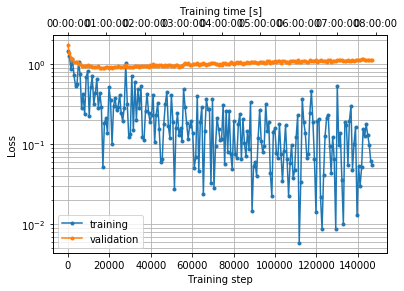

In [109]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [110]:
model.evaluate(x_train, labels_train)

NameError: name 'x_train' is not defined

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [17]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 81.41 (4179 / 5133), f1 (weighted): 80.68, loss: 7.91e-01\nCPU time: 22s, wall time: 21s',
 81.41437755698422,
 80.67557539015563,
 0.791224667511789)

In [18]:
model.evaluate(val_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 80.91 (4153 / 5133), f1 (weighted): 80.18, loss: 7.90e-01\nCPU time: 17s, wall time: 16s',
 80.90785115916617,
 80.18294874128193,
 0.7897724651951272)

In [129]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [135]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [127]:
ids_val = val_dataset.get_ids()

In [20]:
#predictions = predictions.astype(np.int)

In [119]:
from SHREC17.load_shrec import shrec_output

In [136]:
shrec_output(model.get_descriptor(val_dataset), ids_val, probabilities, datapath, 'results/val_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [137]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [36]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

10265it [00:10, 954.60it/s]


In [20]:
test_nonrot_dataset = Shrec17DatasetCache(datapath, 'test', perturbed=noise_dataset, download=download, 
                                          nside=Nside, experiment='deepsphere_norot', augmentation=augmentation, nfile=None)

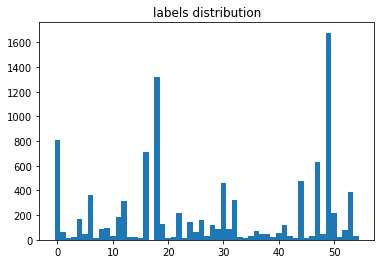

In [37]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [22]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 76.83 (23660 / 30795), f1 (weighted): 76.66, loss: 9.70e-01\nCPU time: 64s, wall time: 57s',
 76.83065432700114,
 76.6615539577081,
 0.9696400432090013)

In [23]:
model.evaluate(test_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 76.78 (23645 / 30795), f1 (weighted): 76.53, loss: 9.65e-01\nCPU time: 132s, wall time: 140s',
 76.7819451209612,
 76.53133646828093,
 0.9650041672563684)

In [ ]:
#predictions = model.predict(x_test)

In [39]:
probabilities = model.probs(x_test, nclass)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


In [138]:
probabilities, _ = model.probs(test_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [41]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [140]:
shrec_output(model.get_descriptor(LabeledDataset(x_test, labels_test)), ids_test, probabilities, datapath, 'results/test_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


Why not working?

In [141]:
def _print_histogram(nclass, labels_train, labels_min=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,1700)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

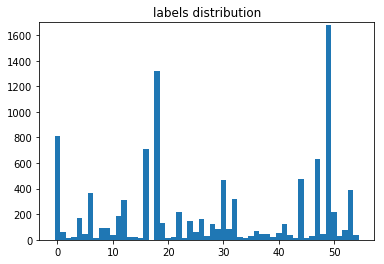

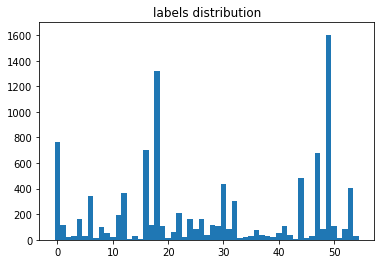

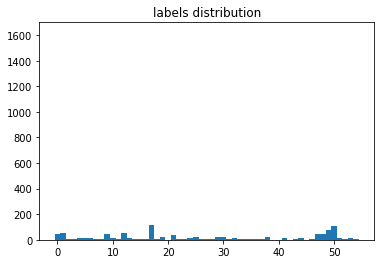

In [142]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)
_print_histogram(55, labels_test, predictions)

In [144]:
from sklearn.metrics import confusion_matrix

In [162]:
conf_mat = confusion_matrix(labels_test, predictions, range(55))

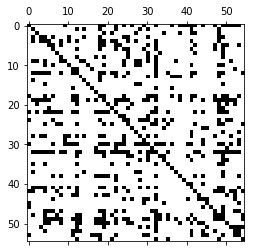

In [164]:
plt.spy(conf_mat, cmap = plt.cm.gist_heat_r)

In [187]:
lab1 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=1))[::-1][:7]

In [188]:
lab2 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=0))[::-1][:7]

In [178]:
dict_labels = {0: 'airplane',
               1: 'trashcan',
               2: 'bag',
               3: 'basket',
               4: 'bathtub',
               5: 'bed',
               6: 'bench',
               7: 'birdhouse',
               8: 'bookshelf',
               9: 'bottle',
               10: 'bowl',
               11: 'bus',
               12: 'cabinet',
               13: 'camera',
               14: 'can',
               15: 'cap',
               16: 'car',
               17: 'cellphone',
               18: 'chair',
               19: 'clock',
               20: 'keyboard',
               21: 'dishwasher',
               22: 'display',
               23: 'earphone',
               24: 'faucet',
               25: 'file cabinet',
               26: 'guitar',
               27: 'helmet',
               28: 'jar',
               29: 'knife',
               30: 'lamp',
               31: 'laptop',
               32: 'speaker',
               33: 'mailbox',
               34: 'microphone',
               35: 'microwave',
               36: 'motorcycle',
               37: 'mug',
               38: 'piano',
               39: 'pillow',
               40: 'pistol',
               41: 'flowerpot',
               42: 'printer',
               43: 'remote control',
               44: 'rifle',
               45: 'rocket',
               46: 'skateboard',
               47: 'sofa',
               48: 'stove',
               49: 'table',
               50: 'telephone',
               51: 'tower',
               52: 'train',
               53: 'vessel',
               54: 'washer'}

In [189]:
[dict_labels[lab] for lab in lab1]

['table', 'cabinet', 'telephone', 'speaker', 'lamp', 'bench', 'chair']

In [190]:
[dict_labels[lab] for lab in lab2]

['cabinet', 'table', 'speaker', 'cellphone', 'sofa', 'chair', 'lamp']